## Import necessary libraries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Conv2D, Rescaling, MaxPooling2D, add, concatenate
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.interpolate import RectBivariateSpline
from scipy.spatial.distance import euclidean
from scipy import signal
from fastdtw import fastdtw
from pymatreader import read_mat
import json
import numpy as np
import pandas as pd
import pywt
import os
import scipy.io
import h5py
import matplotlib.pyplot as plt
import glob

## Load the data

The dataset is composed of a spreadshit and multiple .mat files containing the SCG measurements.

In [4]:
# Return the location of excel file
csv_dir = r'Z:\forEthan\dat-scg\scg-subj-list.xlsx'

# Check if the file exists before trying to read it
if os.path.isfile(csv_dir):
    
    # Read in (or create) data.
    df = pd.read_excel(csv_dir)
    
    # Remove rows with missing values in the specified columns
    df = df.dropna(subset=["sex","age [y]","ht [m]","wt [kg]","vmax [cm/s]","as","valve"]).reset_index()
    df = df[['expdfile','subjid','ctrl','sex','age [y]','ht [m]','wt [kg]','vmax [cm/s]','as','valve']]
else:
    print("File not found")

# Read the AS (aortic stenosis) column of the df dataframe as strings
as_condition = df["as"].astype(str)

# Read the valve column of the df dataframe as strings
valve = df["valve"].astype(str)

# Combine the AS and valve conditions to create the as_valve attribue for the subjects
as_valve = [a1 + "-AS_" + b1 if a1=="none" else "AS" for (a1, b1) in zip(as_condition, valve)]
df['as_valve'] = as_valve

# Report number of subjects within each as_valve condition
for condition in set(as_valve):
    print(f"{condition}: {sum([valve==condition for valve in as_valve])}")

# Report the distribution of the subjects
print("Total subjects: ", len(df))
print(f"Healthy subjects: {(df['ctrl'] == 'y').sum()}, females: {((df['ctrl'] == 'y') & (df['sex'] == 'F')).sum()}")
print(f"Patient subjects: {(df['ctrl'] == 'n').sum()}, females: {((df['ctrl'] == 'n') & (df['sex'] == 'F')).sum()}")

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit the one-hot encoder on the "sex" column of the dataframe
df['sex'] = encoder.fit_transform(df['sex'].values.reshape(-1,1)).toarray()[:,0]

# Fit the one-hot encoder on the "as_valve" column of the dataframe
encAsValve = encoder.fit_transform(df['as_valve'].values.reshape(-1,1)).toarray()
encAsValve_dict = {}
for ii, subjid in enumerate(df['subjid'].tolist()):
    encAsValve_dict[subjid] = encAsValve[ii,:]
print("The one-hot encoded as_valve conidtion:\n",encAsValve_dict[subjid])

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit min-max scaling transformation to the data
df['age [y]'] = scaler.fit_transform(df['age [y]'].values.reshape(-1, 1))
df['ht [m]'] = scaler.fit_transform(df['ht [m]'].values.reshape(-1, 1))
df['wt [kg]'] = scaler.fit_transform(df['wt [kg]'].values.reshape(-1, 1))

# Specify the folder containing the SCG data
fldr = r'Z:\forEthan\dat-scg'
scg_files = glob.glob(os.path.join(fldr,'scg_*.mat'))
scg_files = [scg_file for scg_file in scg_files if os.path.split(scg_file)[1] in df['expdfile'].values]
print('SCG file paths:\n', scg_files)

# Create a dictionary mapping each scg file path to its corresponding expdfile in the dataframe
scg_dict = {}
for expdfile in df['expdfile'].values:
    scg_dict[expdfile] = "".join([scg_file for scg_file in scg_files if os.path.split(scg_file)[1]==expdfile])
df['scg_files'] = df['expdfile'].map(scg_dict)

df

none-AS_BAV: 10
none-AS_mech: 9
AS: 12
none-AS_TAV: 46
Total subjects:  77
Healthy subjects: 46, females: 20
Patient subjects: 31, females: 6
The one-hot encoded as_valve conidtion:
 [0. 1. 0. 0.]
SCG file paths:
 ['Z:\\forEthan\\dat-scg\\scg_cmr000.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr002.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr004.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr005.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr006.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr007.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr008.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr009.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr010.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr011.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr012.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr013.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr014.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr015.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr016.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr018.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr019.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr020.mat', 'Z:\\forEthan\\dat-scg\\scg_cmr024.mat', 'Z:\\f

expdfile  subjid ctrl  sex   age [y]    ht [m]   wt [kg]  \
0   scg_cmr000.mat  CMR000    y  0.0  0.869565  0.347692  0.497734   
1   scg_cmr038.mat  CMR038    y  1.0  0.956522  0.075385  0.062626   
2   scg_cmr040.mat  CMR040    y  1.0  0.666667  0.309231  0.606511   
3   scg_cmr052.mat  CMR052    y  0.0  0.420290  0.504615  0.443345   
4   scg_cmr068.mat  CMR068    y  0.0  0.275362  0.426154  0.481415   
..             ...     ...  ...  ...       ...       ...       ...   
72  scg_cmr983.mat  CMR983    n  0.0  0.014493  0.307692  0.328537   
73  scg_cmr982.mat  CMR982    n  0.0  0.072464  0.523077  0.352518   
74  scg_cmr981.mat  CMR981    n  0.0  0.101449  0.338462  0.160671   
75  scg_cmr980.mat  CMR980    n  0.0  0.072464  0.676923  0.616307   
76  scg_cmr979.mat  CMR979    n  0.0  0.057971  0.600000  0.430456   

    vmax [cm/s]        as valve     as_valve  \
0         137.3      none   TAV  none-AS_TAV   
1          99.8      none   TAV  none-AS_TAV   
2         139.2      none   TAV  none-AS_TAV   
3         127.9      none   TAV  none-AS_TAV   
4         148.9      none   TAV  none-AS_TAV   
..          ...       ...   ...          ...   
72        151.2      none   BAV  none-AS_BAV   
73        289.4  moderate   BAV           AS   
74        290.2  moderate   BAV           AS   
75        190.7      none   BAV  none-AS_BAV   
76        243.0      none   BAV  none-AS_BAV   

                             scg_files  
0   Z:\forEthan\dat-scg\scg_cmr000.mat  
1   Z:\forEthan\dat-scg\scg_cmr038.mat  
2   Z:\forEthan\dat-scg\scg_cmr040.mat  
3   Z:\forEthan\dat-scg\scg_cmr052.mat  
4   Z:\forEthan\dat-scg\scg_cmr068.mat  
..                                 ...  
72  Z:\forEthan\dat-scg\scg_cmr983.mat  
73  Z:\forEthan\dat-scg\scg_cmr982.mat  
74  Z:\forEthan\dat-scg\scg_cmr981.mat  
75  Z:\forEthan\dat-scg\scg_cmr980.mat  
76  Z:\forEthan\dat-scg\scg_cmr979.mat  

[77 rows x 12 columns]

## Signal processing 

The signal processing is composed of four steps:
1. High pass filtering 
    - We use ```signal.butter()``` function of the ```scipy``` module.
2. Wavelet denoising
    - We use the wavelet harthresholding using the ```pywt``` module.
3. Outlier removal using DTW (dynamic time warping)
    - We use the ```fastdtw``` module to minimize the Euclidean distance between the SCGs and a reference signal (mean of SCGs) 
4. Continuous wavelet transform to calculate the scalograms
    - We use the ``py.cwt(data, scales, wavelet)`` 
    - The appropriate scales can be determined using ``freqs = pywt.scale2frequency(wavelet, scales) * fs``
        - For example, use the function ``scale_selection(t, voicesperoctave=32, wavelet='cmor1.5-1.0')`` to find the start and end scales whose frequency range ends within the range of interest.
    - The frequency content of the SCG signals are typically within the range of 10 - 100 Hz.

Subject 0: Number of recorded heart beats (HB): 108, and data points per HB: 955 


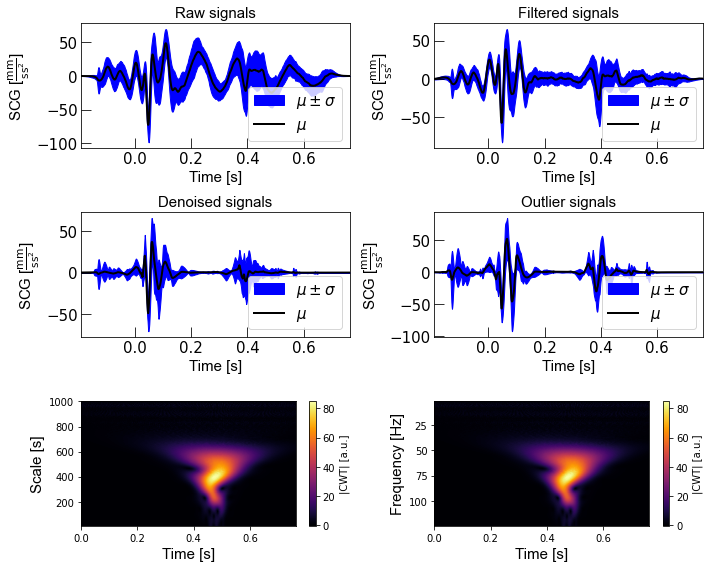

Subject 1: Number of recorded heart beats (HB): 82, and data points per HB: 803 


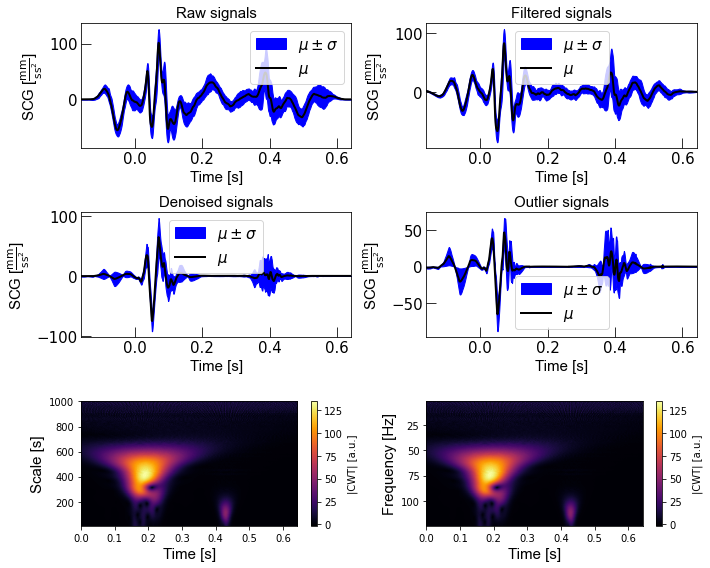

Subject 2: Number of recorded heart beats (HB): 120, and data points per HB: 949 


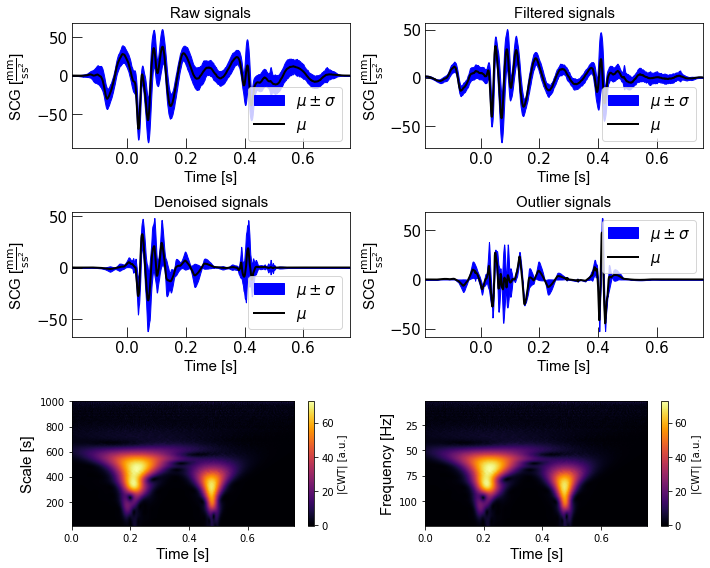

Subject 3: Number of recorded heart beats (HB): 67, and data points per HB: 775 


C:\Users\mem1342\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mem1342\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\mem1342\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mem1342\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\mem1342\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


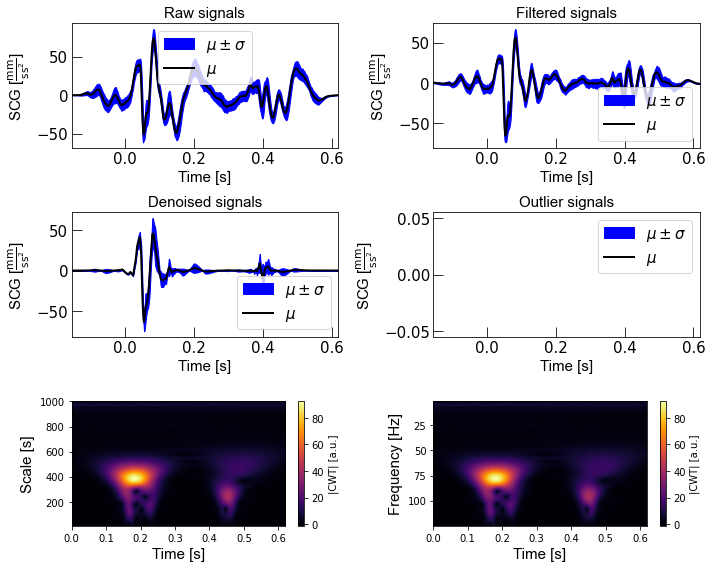

Subject 4: Number of recorded heart beats (HB): 84, and data points per HB: 828 


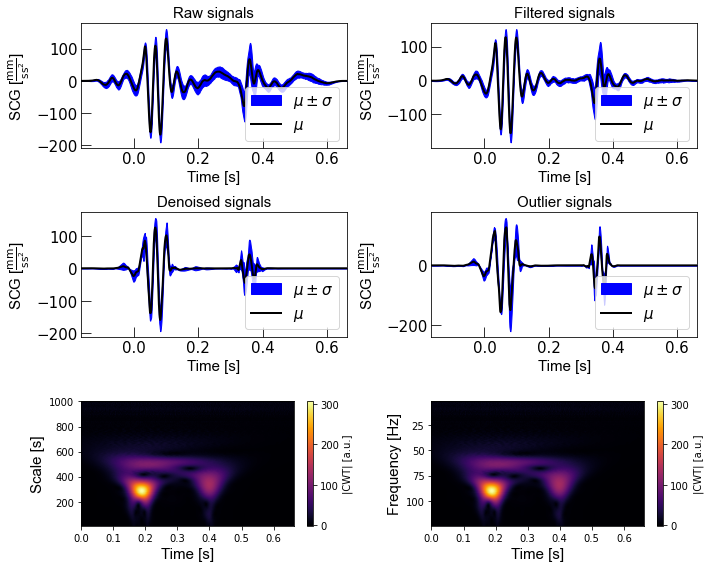

Subject 5: Number of recorded heart beats (HB): 103, and data points per HB: 840 


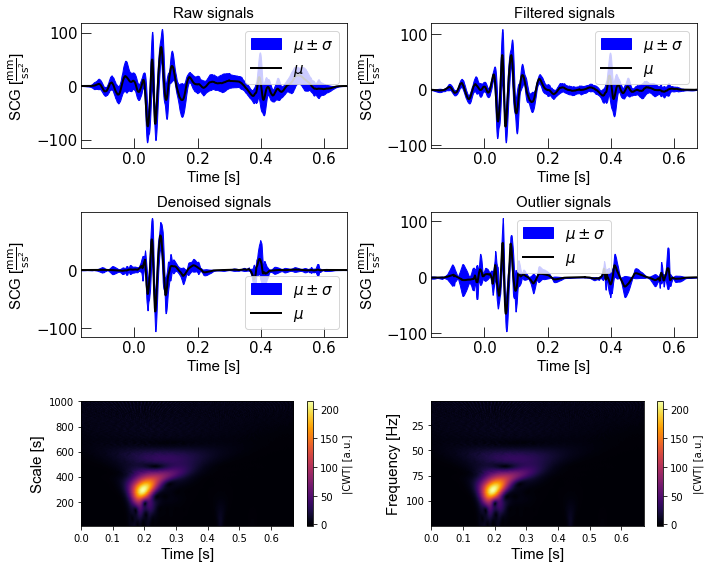

Subject 6: Number of recorded heart beats (HB): 42, and data points per HB: 733 


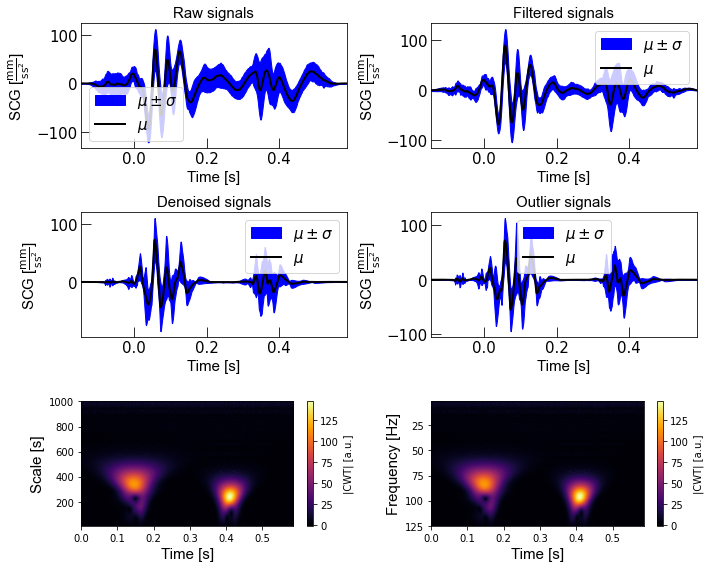

Subject 7: Number of recorded heart beats (HB): 39, and data points per HB: 866 


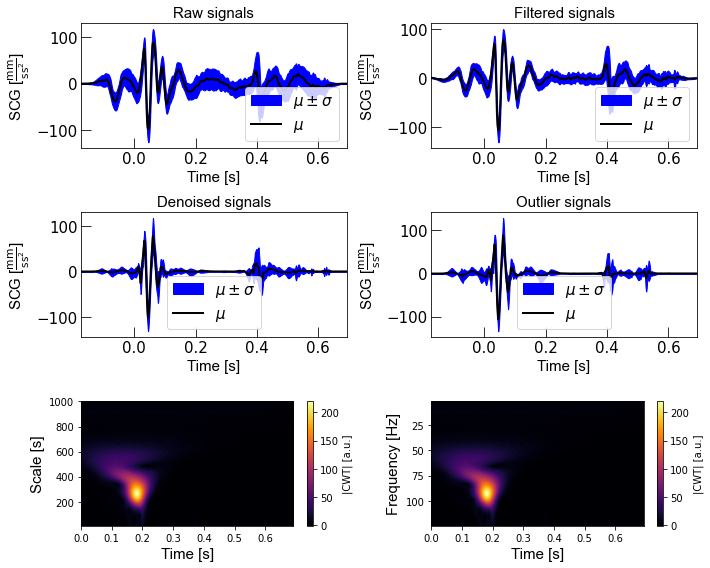

Subject 8: Number of recorded heart beats (HB): 18, and data points per HB: 856 


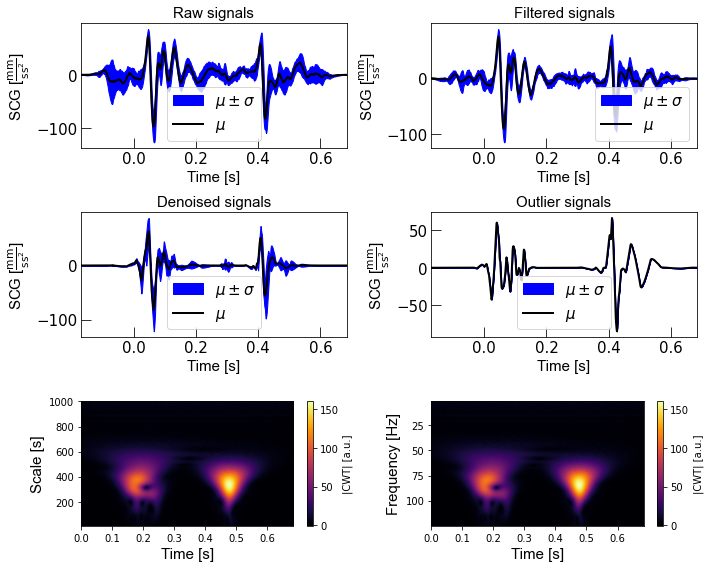

Subject 9: Number of recorded heart beats (HB): 18, and data points per HB: 776 


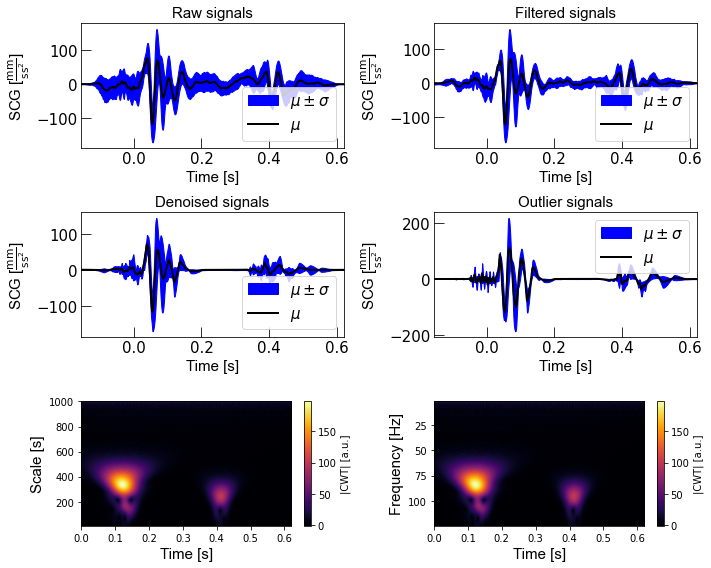

Subject 10: Number of recorded heart beats (HB): 13, and data points per HB: 773 


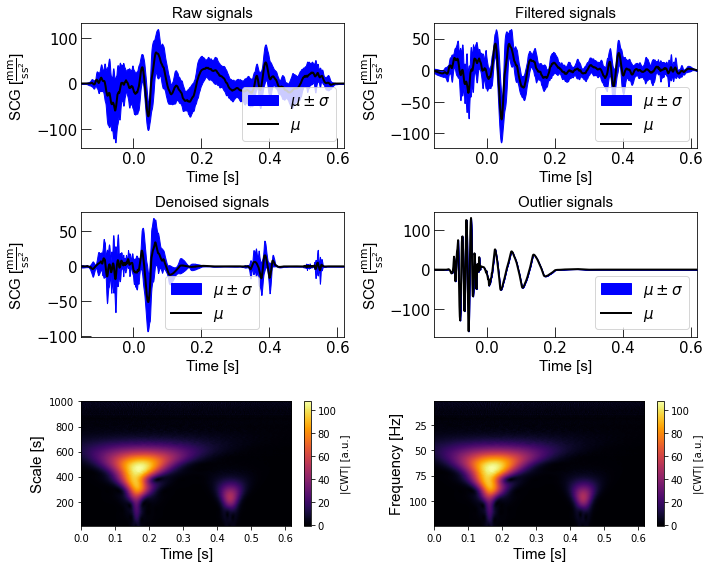

Subject 11: Number of recorded heart beats (HB): 19, and data points per HB: 1037 


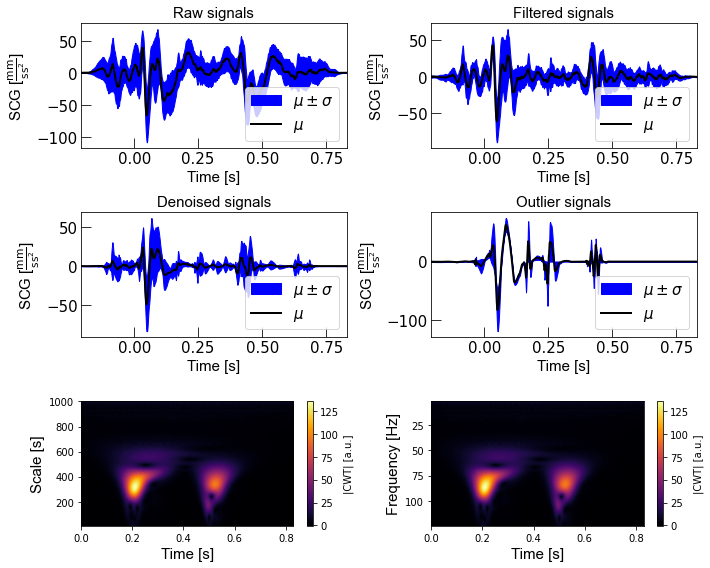

Subject 12: Number of recorded heart beats (HB): 56, and data points per HB: 803 


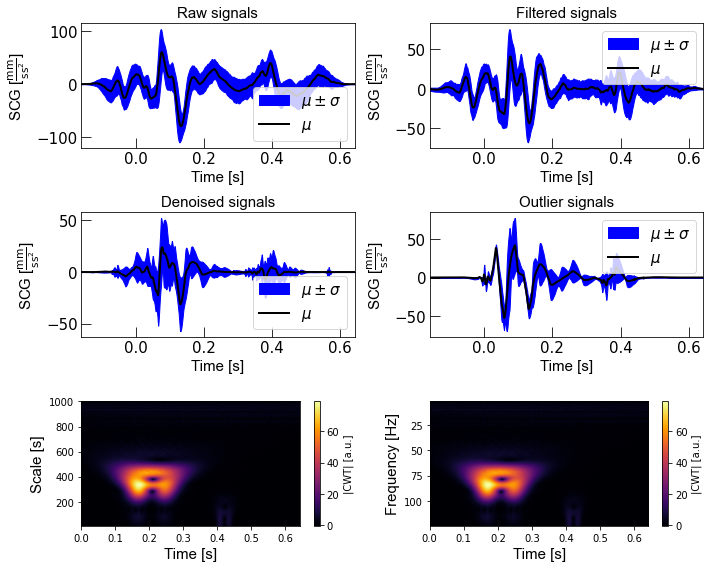

Subject 13: Number of recorded heart beats (HB): 61, and data points per HB: 1049 


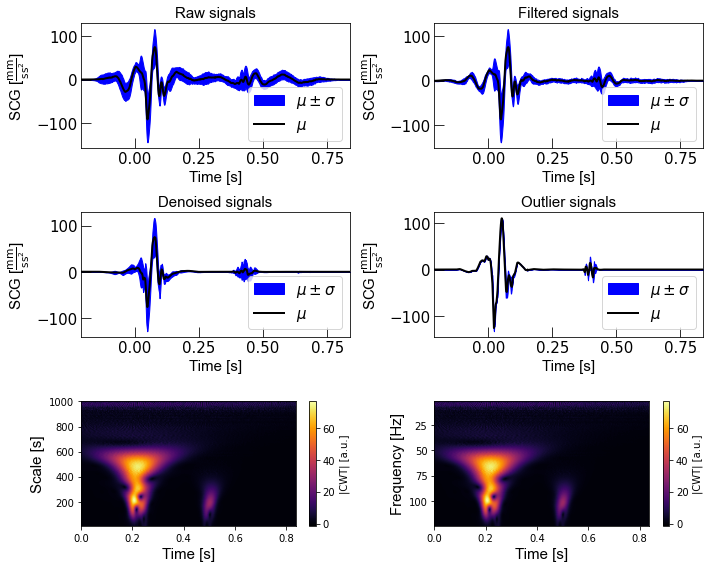

Subject 14: Number of recorded heart beats (HB): 197, and data points per HB: 678 


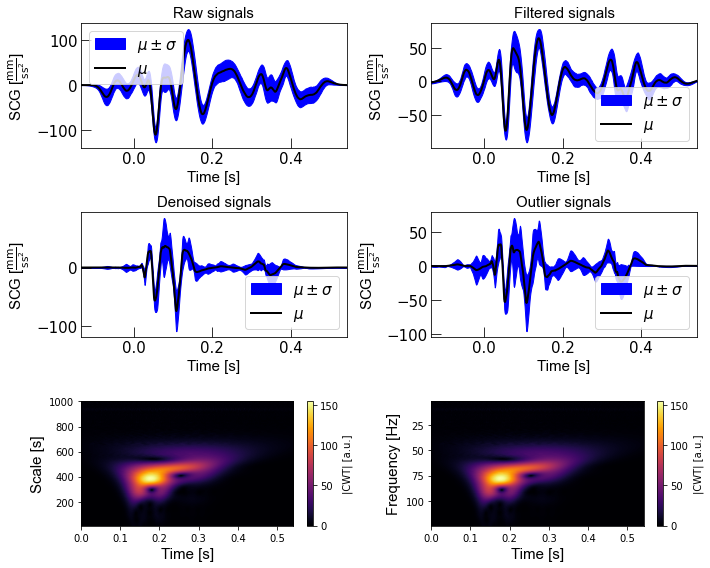

Subject 15: Number of recorded heart beats (HB): 105, and data points per HB: 1106 


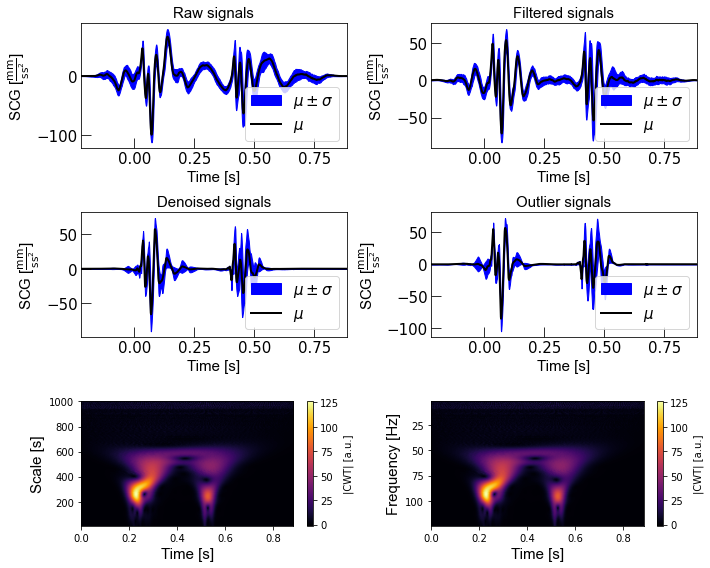

Subject 16: Number of recorded heart beats (HB): 161, and data points per HB: 872 


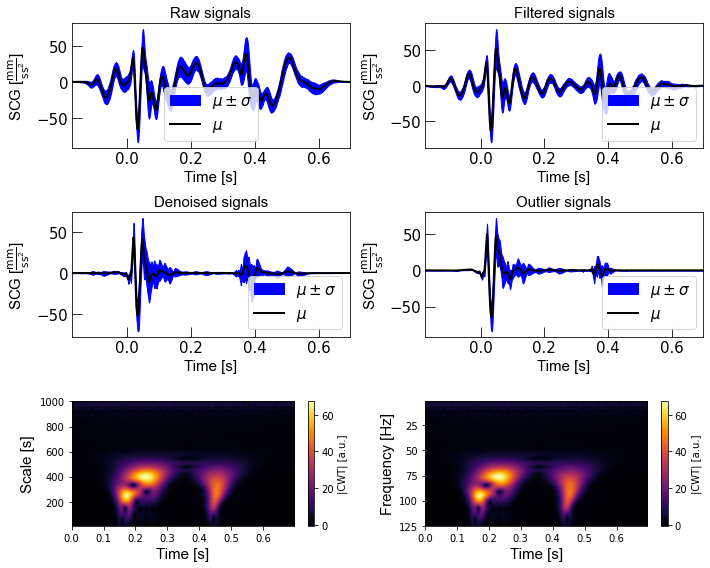

Subject 17: Number of recorded heart beats (HB): 118, and data points per HB: 672 


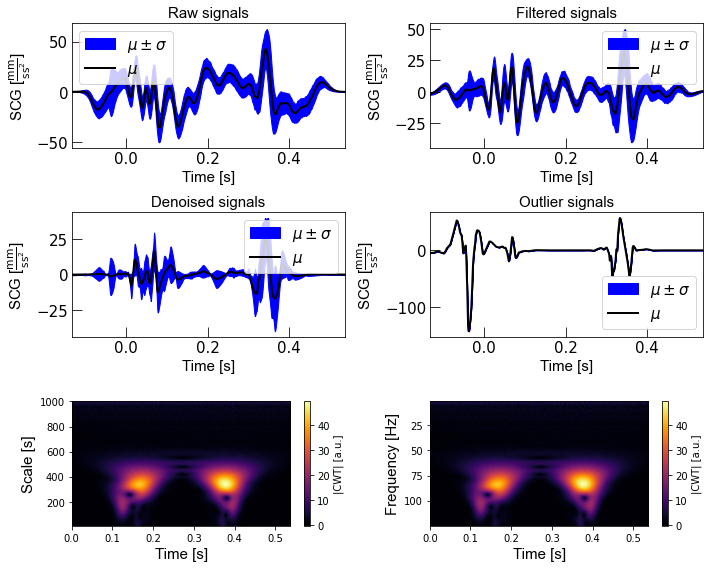

Subject 18: Number of recorded heart beats (HB): 110, and data points per HB: 867 


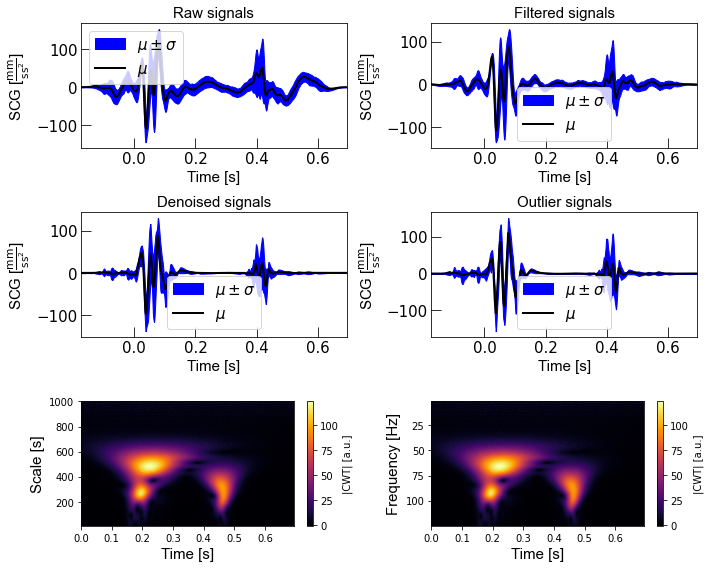

Subject 19: Number of recorded heart beats (HB): 127, and data points per HB: 733 


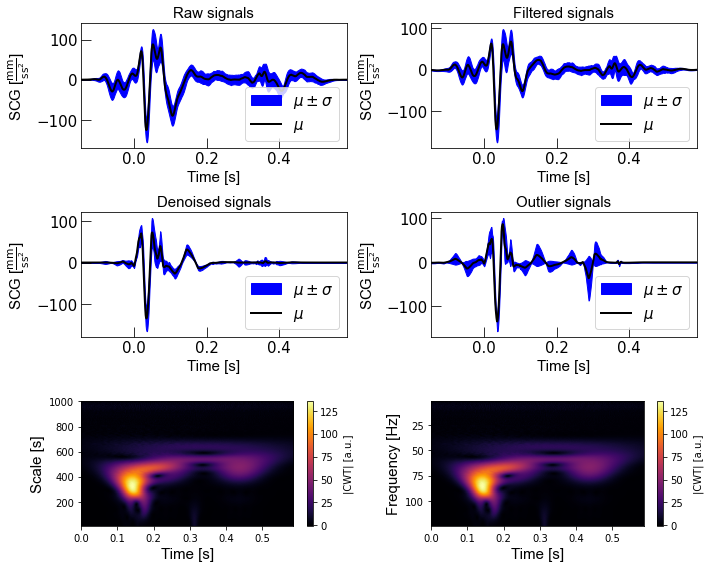

Subject 20: Number of recorded heart beats (HB): 125, and data points per HB: 1099 


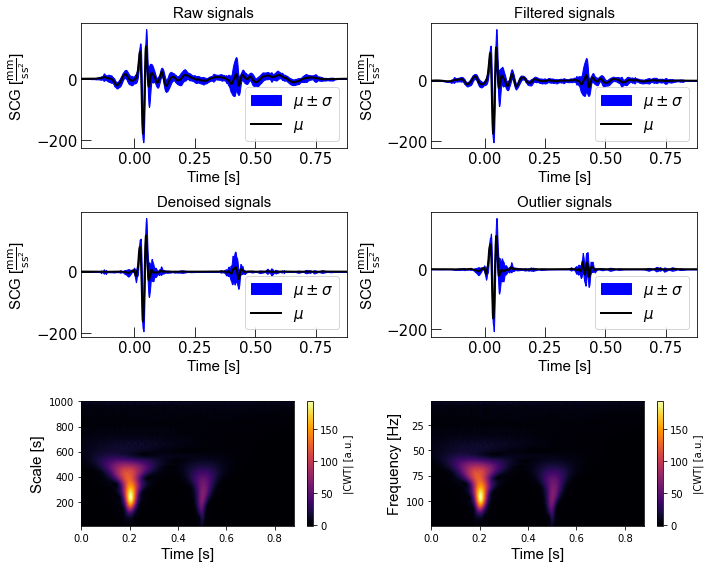

Subject 21: Number of recorded heart beats (HB): 140, and data points per HB: 826 


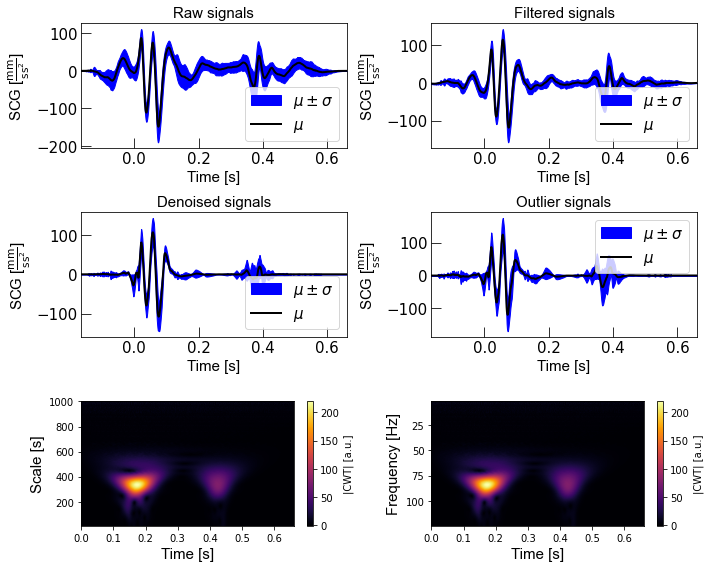

Subject 22: Number of recorded heart beats (HB): 83, and data points per HB: 821 


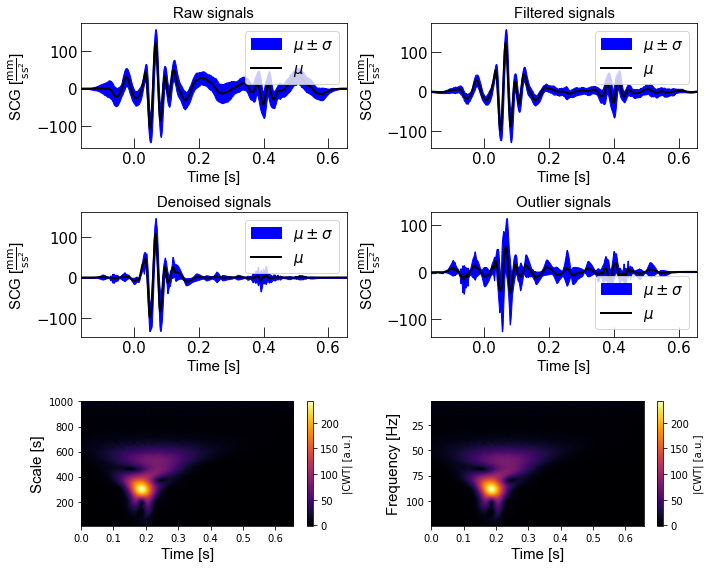

Subject 23: Number of recorded heart beats (HB): 16, and data points per HB: 1012 


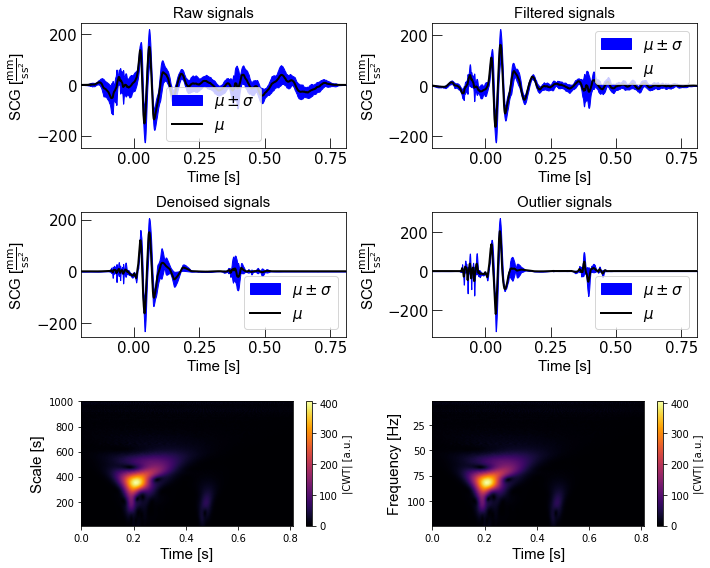

Subject 24: Number of recorded heart beats (HB): 31, and data points per HB: 622 


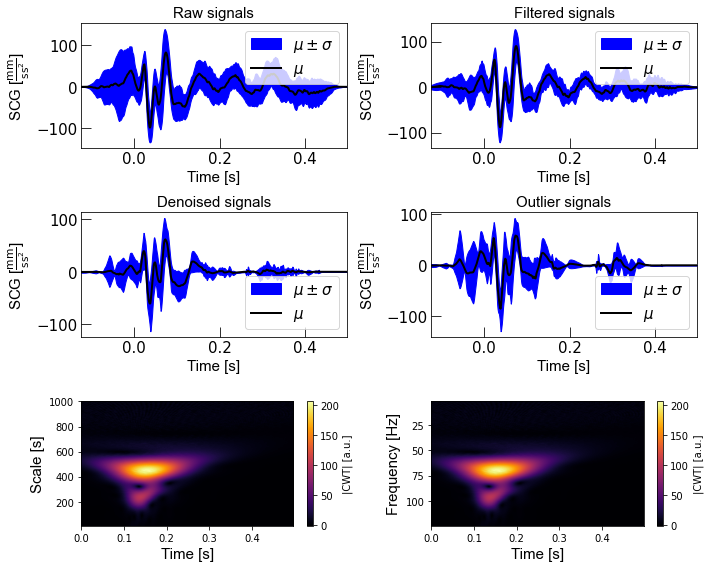

Subject 25: Number of recorded heart beats (HB): 42, and data points per HB: 1045 


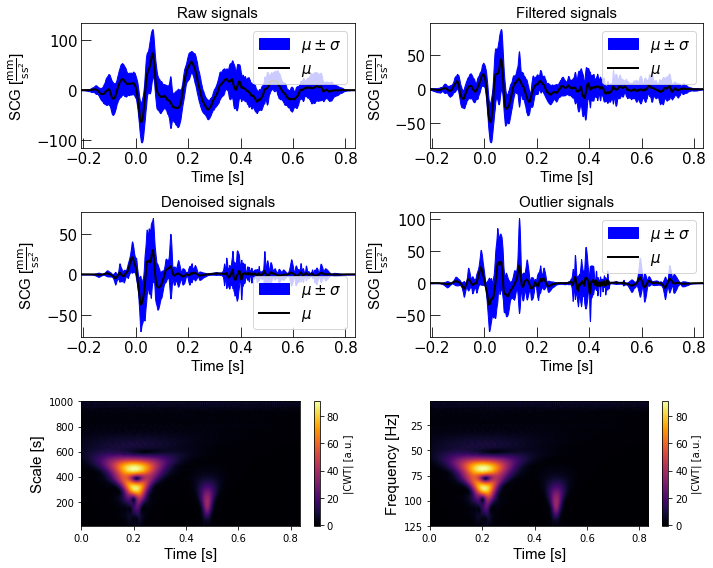

Subject 26: Number of recorded heart beats (HB): 95, and data points per HB: 952 


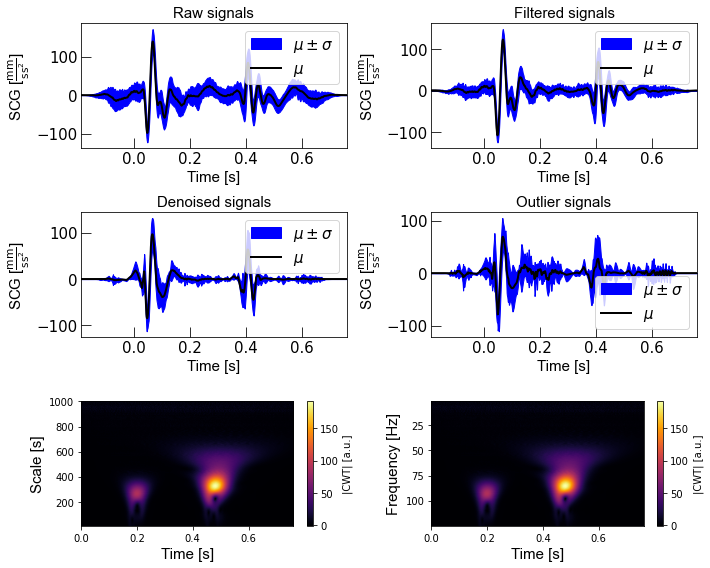

Subject 27: Number of recorded heart beats (HB): 30, and data points per HB: 1258 


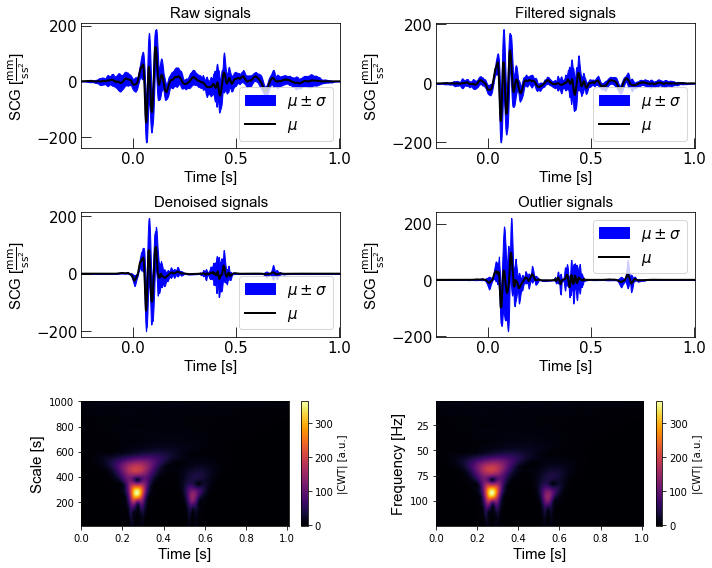

Subject 28: Number of recorded heart beats (HB): 24, and data points per HB: 1029 


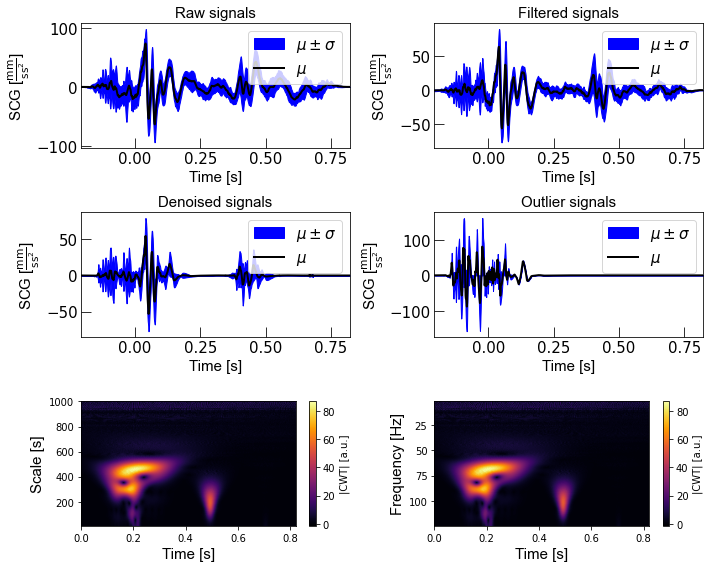

Subject 29: Number of recorded heart beats (HB): 43, and data points per HB: 805 


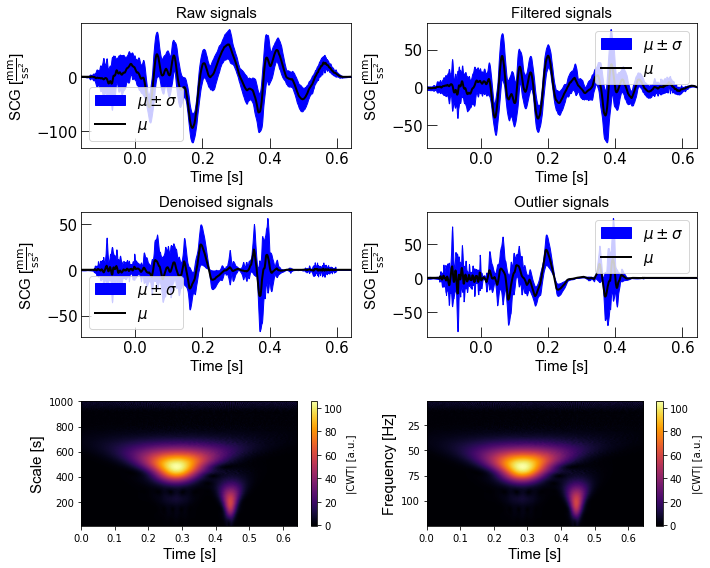

Subject 30: Number of recorded heart beats (HB): 31, and data points per HB: 1074 


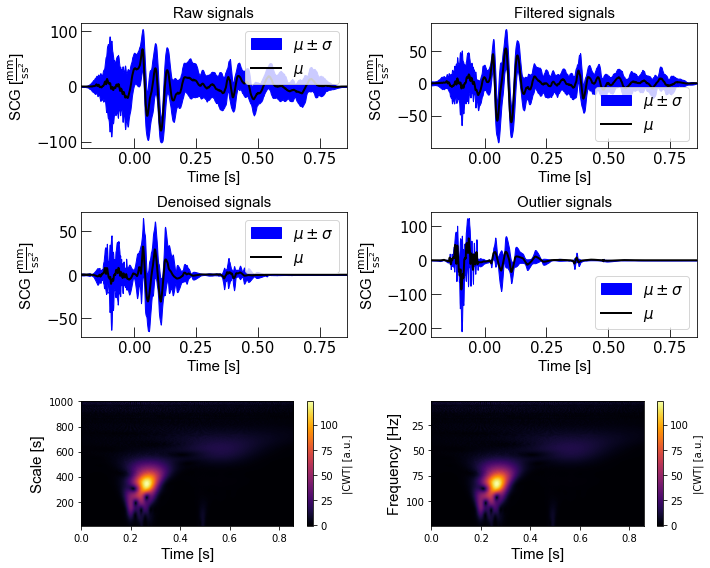

Subject 31: Number of recorded heart beats (HB): 26, and data points per HB: 779 


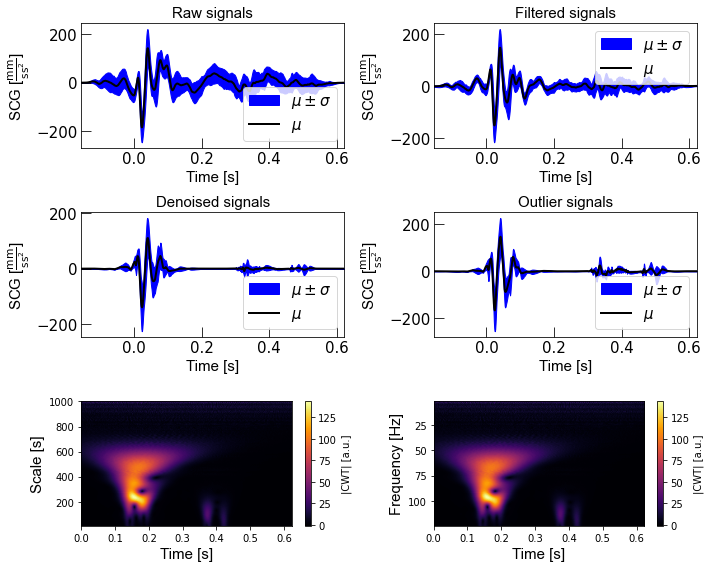

Subject 32: Number of recorded heart beats (HB): 29, and data points per HB: 917 


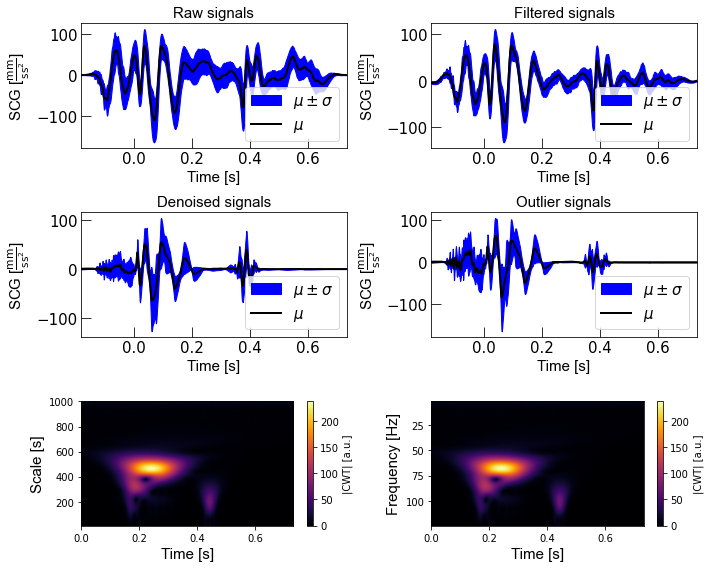

Subject 33: Number of recorded heart beats (HB): 55, and data points per HB: 833 


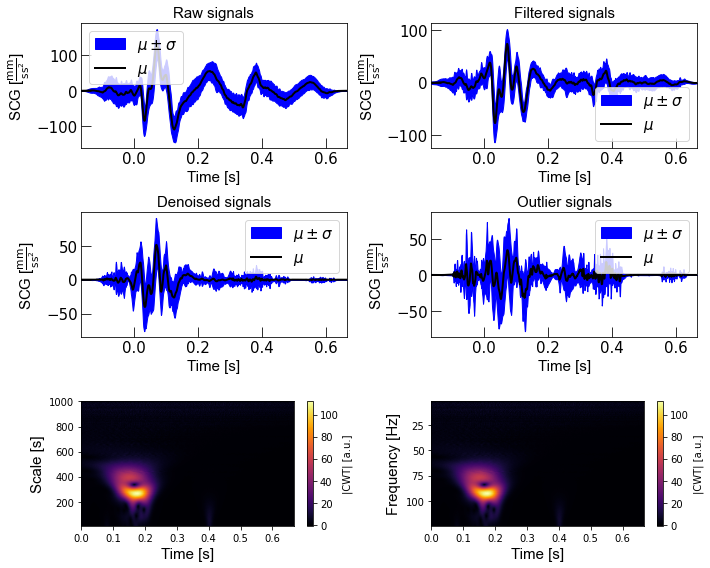

Subject 34: Number of recorded heart beats (HB): 51, and data points per HB: 952 


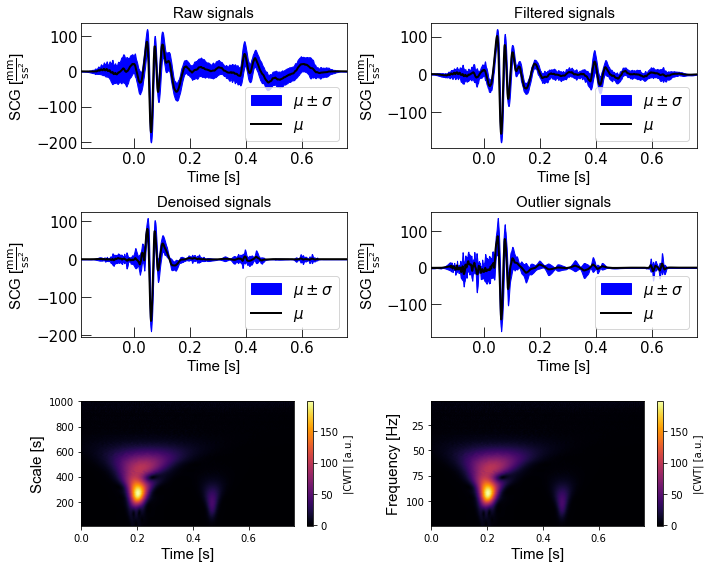

Subject 35: Number of recorded heart beats (HB): 33, and data points per HB: 840 


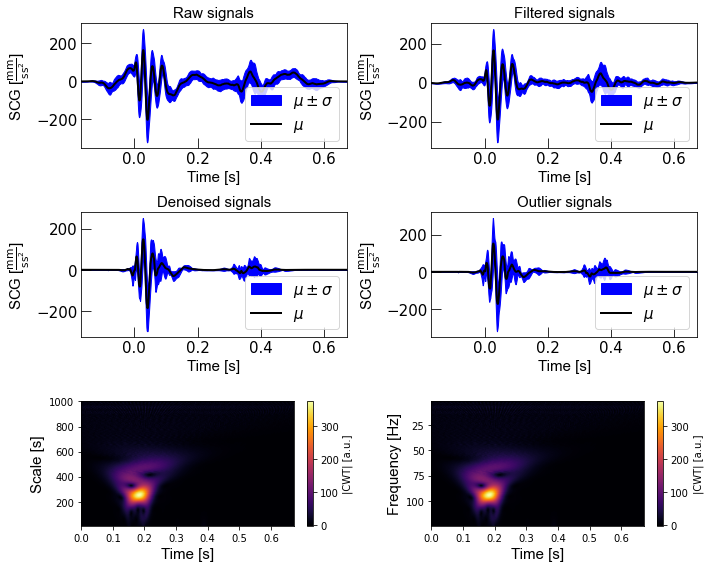

Subject 36: Number of recorded heart beats (HB): 66, and data points per HB: 935 


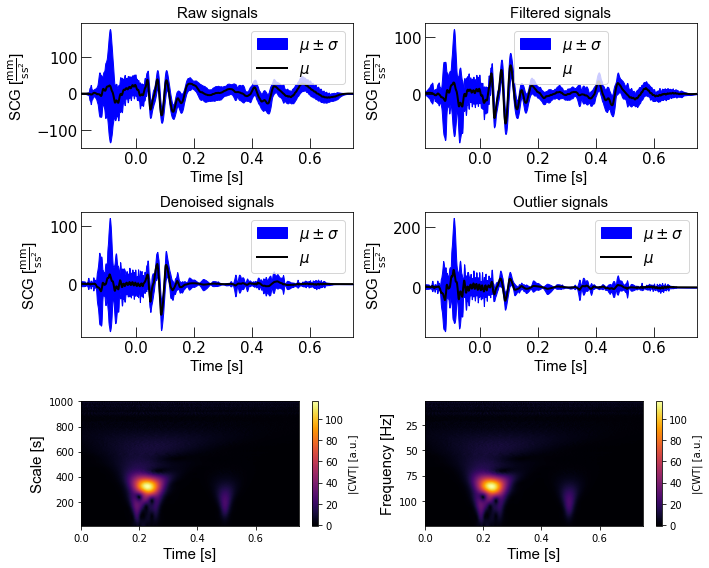

Subject 37: Number of recorded heart beats (HB): 54, and data points per HB: 583 


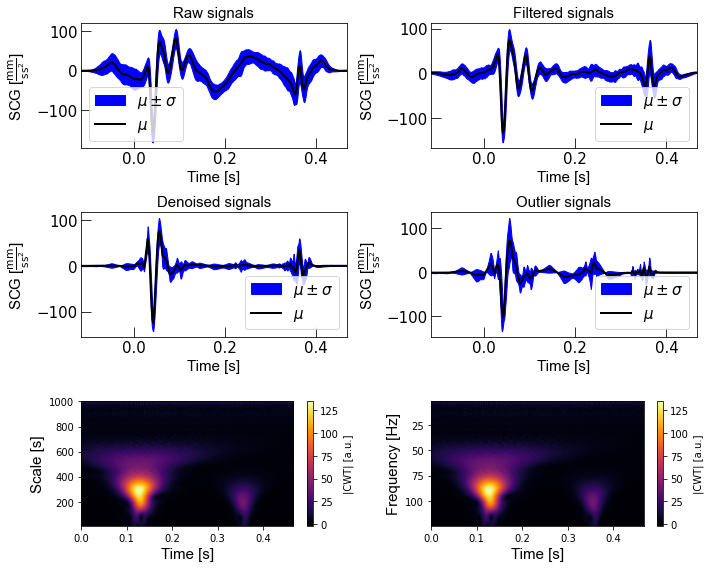

Subject 38: Number of recorded heart beats (HB): 122, and data points per HB: 873 


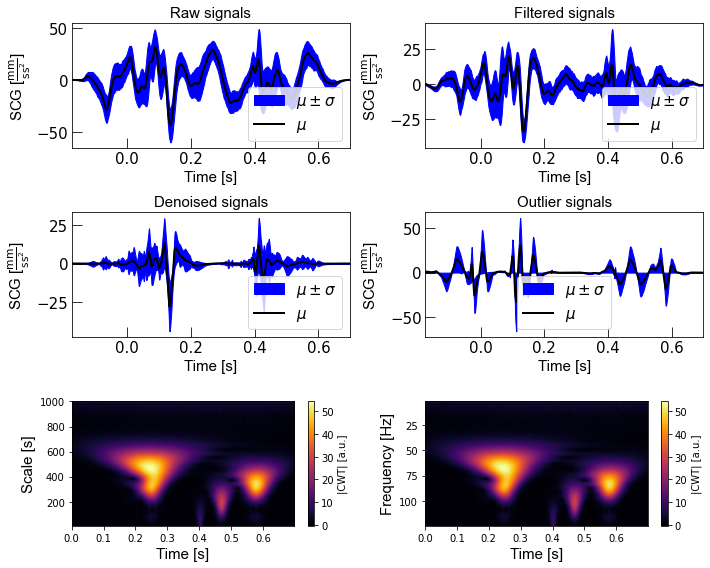

Subject 39: Number of recorded heart beats (HB): 130, and data points per HB: 665 


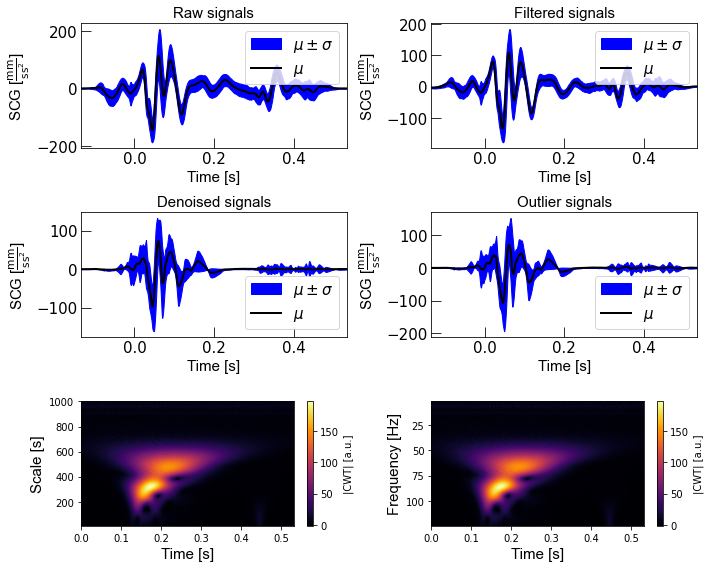

Subject 40: Number of recorded heart beats (HB): 111, and data points per HB: 862 


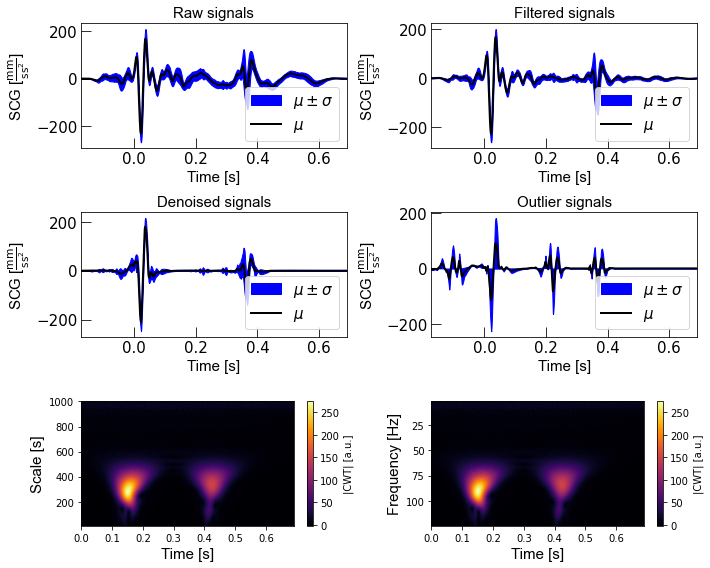

Subject 41: Number of recorded heart beats (HB): 29, and data points per HB: 758 


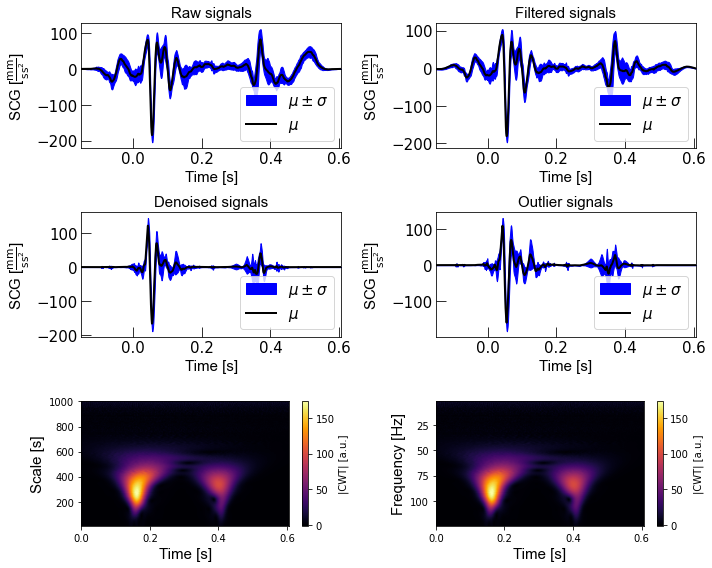

Subject 42: Number of recorded heart beats (HB): 90, and data points per HB: 1076 


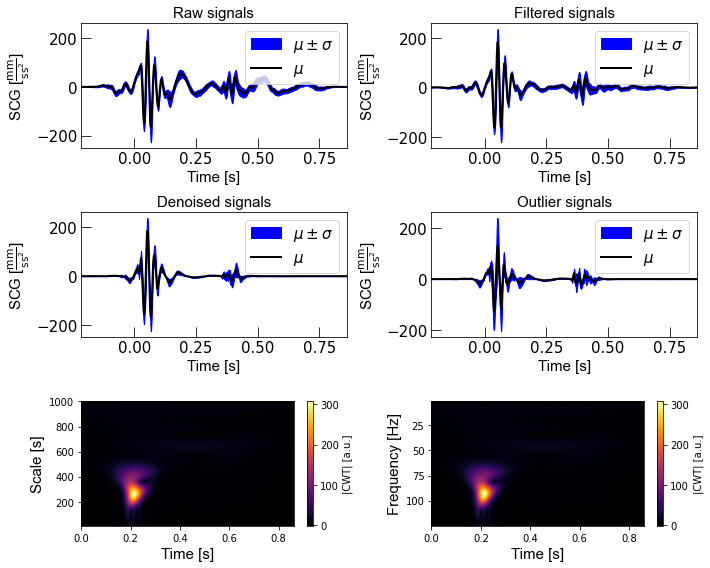

Subject 43: Number of recorded heart beats (HB): 137, and data points per HB: 729 


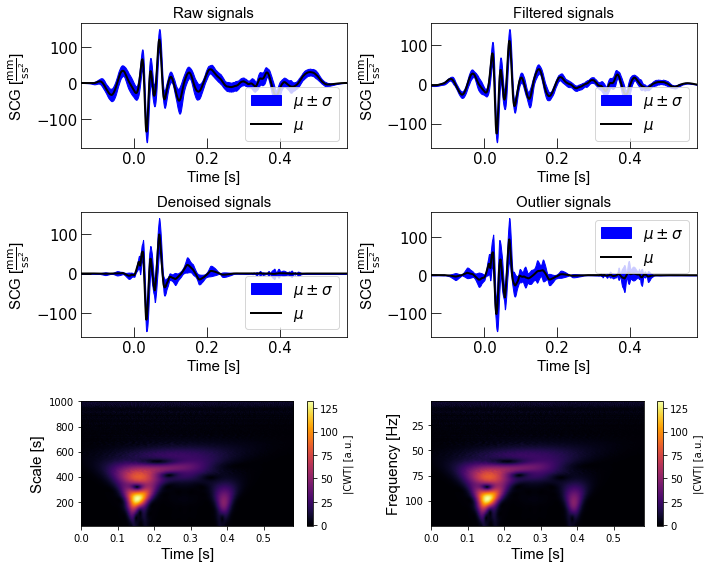

Subject 44: Number of recorded heart beats (HB): 110, and data points per HB: 732 


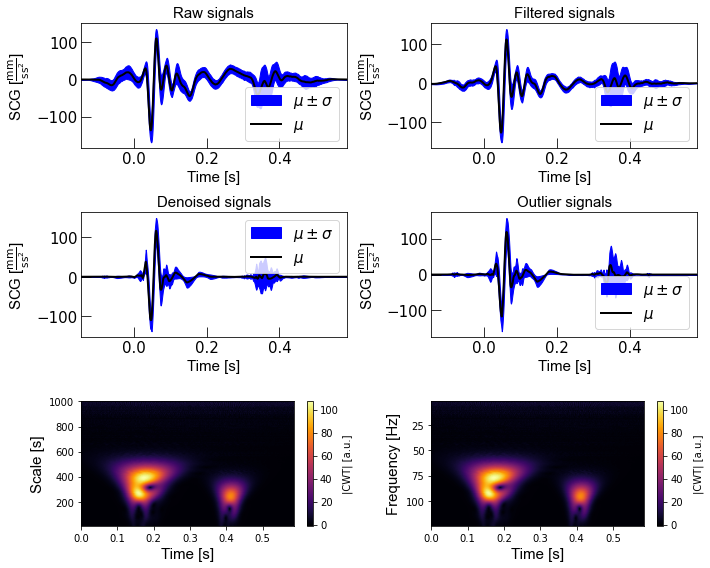

Subject 45: Number of recorded heart beats (HB): 69, and data points per HB: 1281 


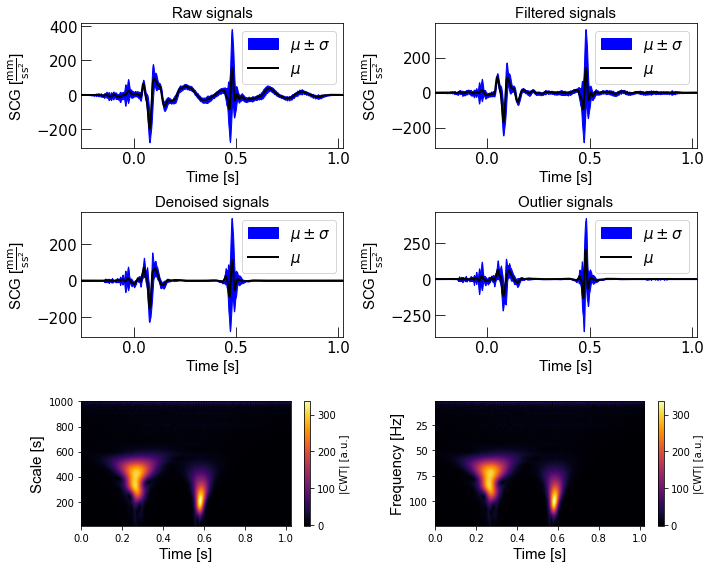

Subject 46: Number of recorded heart beats (HB): 89, and data points per HB: 1328 


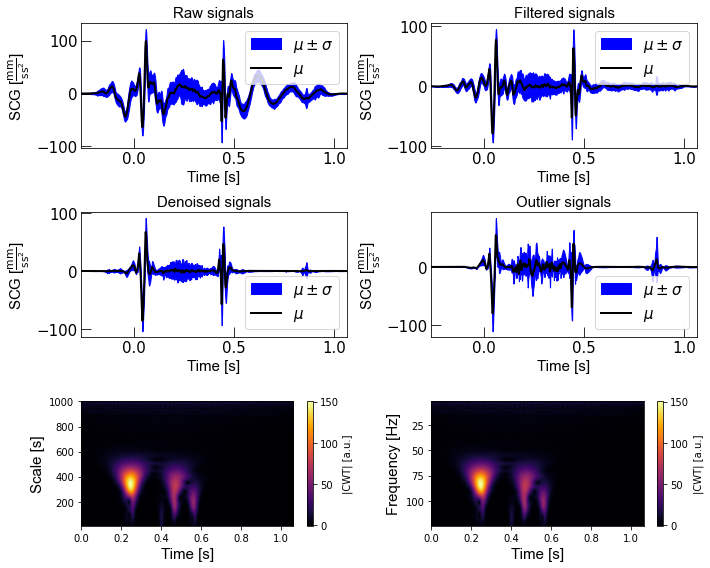

Subject 47: Number of recorded heart beats (HB): 82, and data points per HB: 1194 


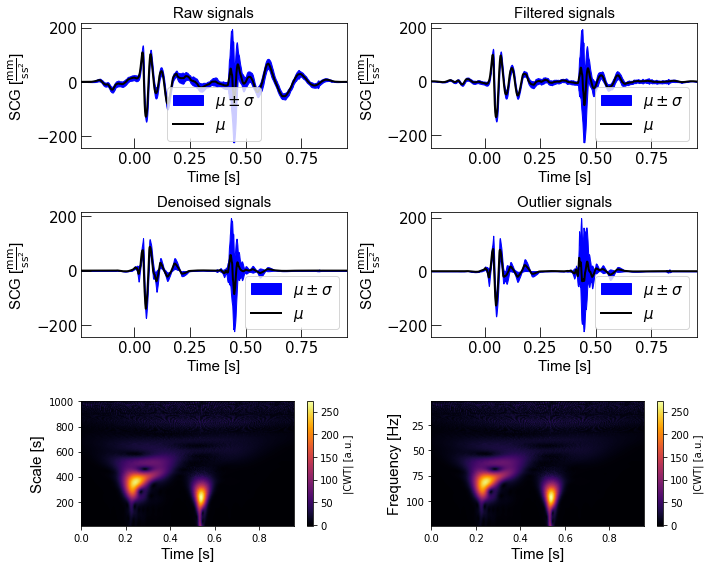

Subject 48: Number of recorded heart beats (HB): 152, and data points per HB: 854 


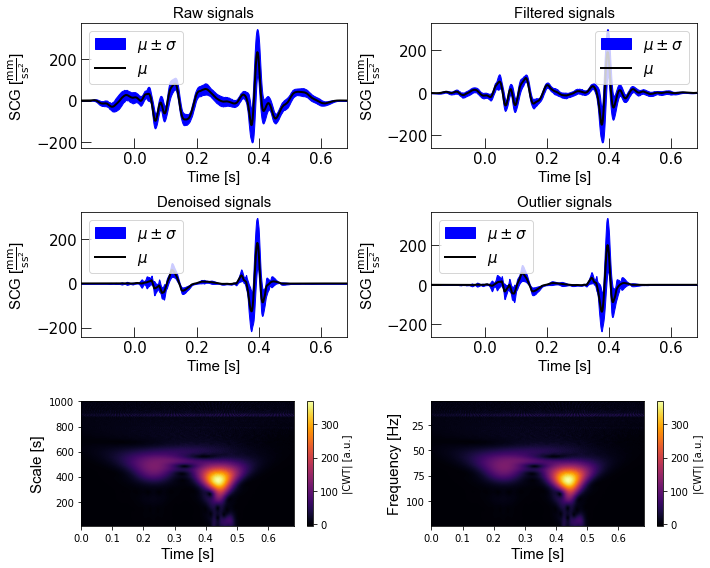

Subject 49: Number of recorded heart beats (HB): 92, and data points per HB: 927 


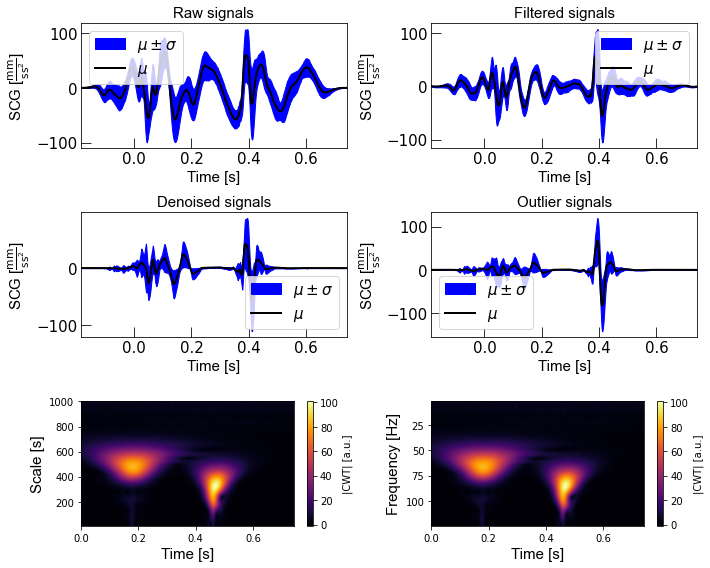

Subject 50: Number of recorded heart beats (HB): 145, and data points per HB: 805 


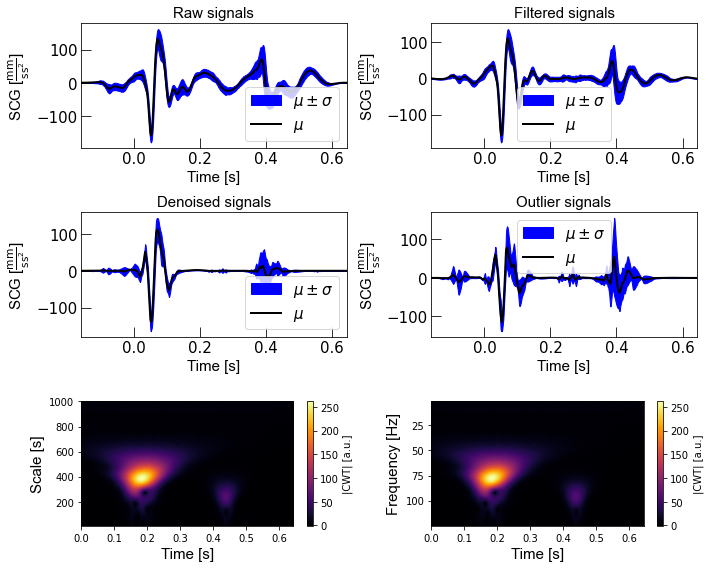

Subject 51: Number of recorded heart beats (HB): 90, and data points per HB: 1067 


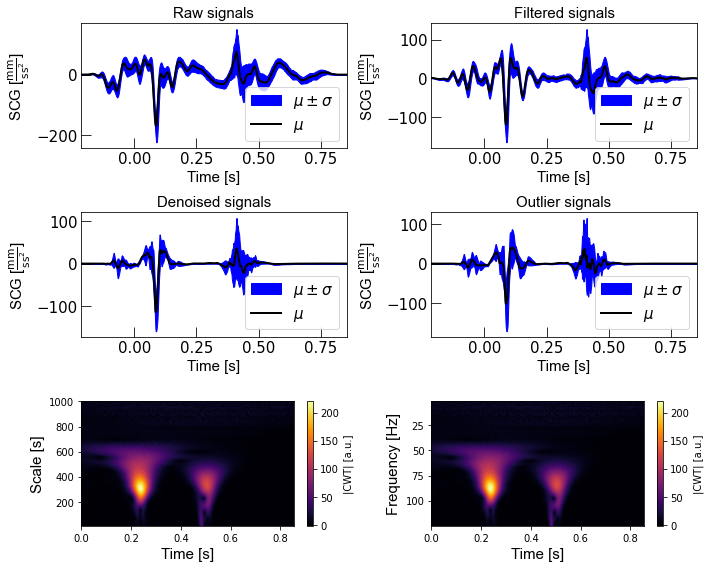

Subject 52: Number of recorded heart beats (HB): 86, and data points per HB: 1099 


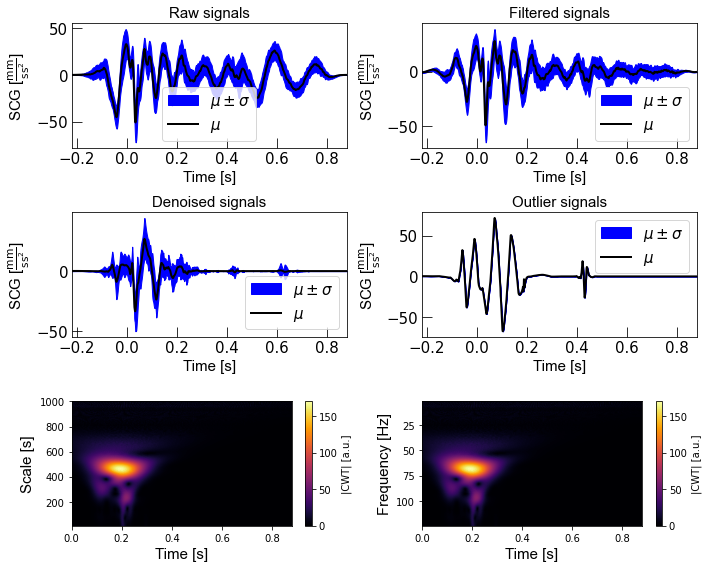

Subject 53: Number of recorded heart beats (HB): 107, and data points per HB: 975 


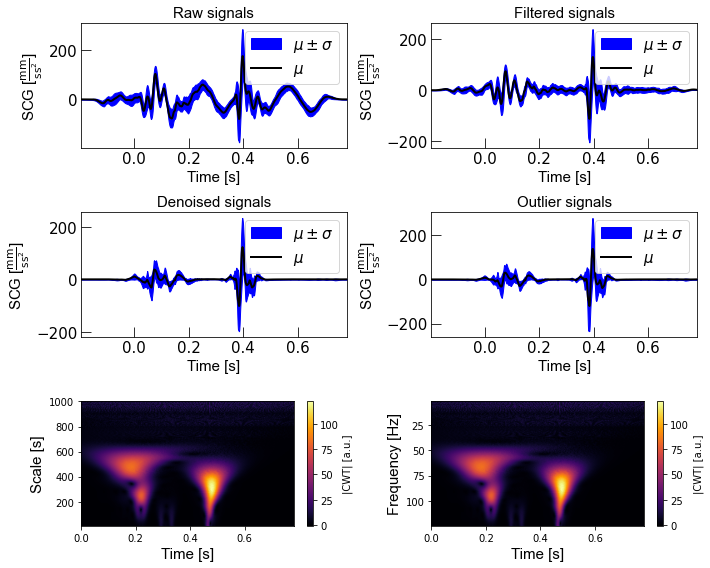

Subject 54: Number of recorded heart beats (HB): 145, and data points per HB: 840 


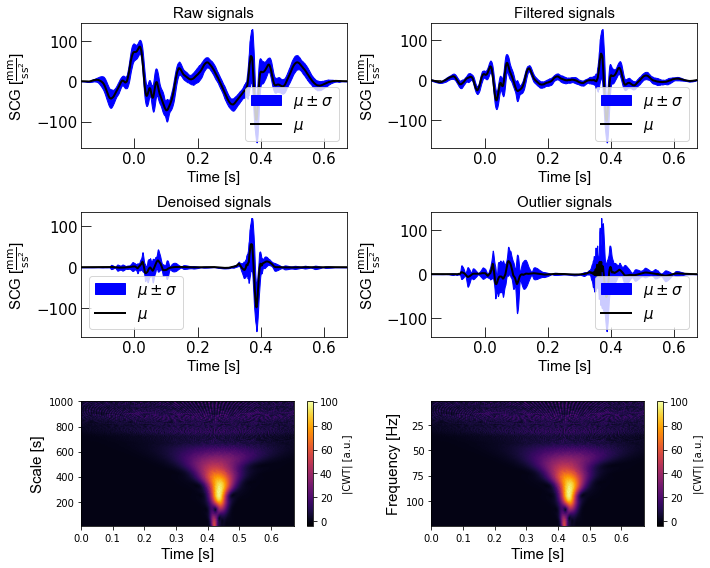

Subject 55: Number of recorded heart beats (HB): 137, and data points per HB: 745 


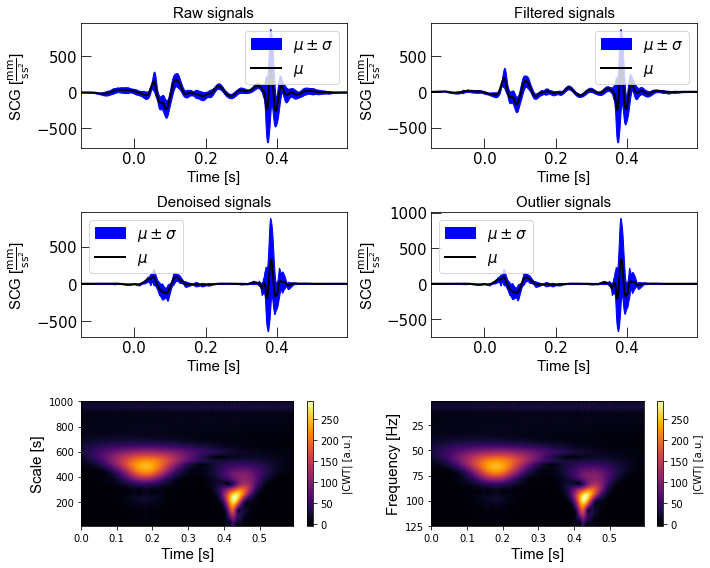

Subject 56: Number of recorded heart beats (HB): 74, and data points per HB: 1024 


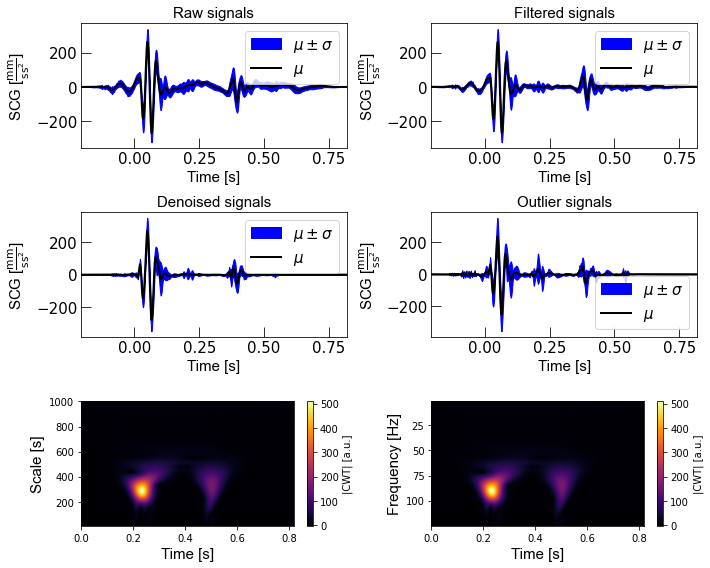

Subject 57: Number of recorded heart beats (HB): 146, and data points per HB: 598 


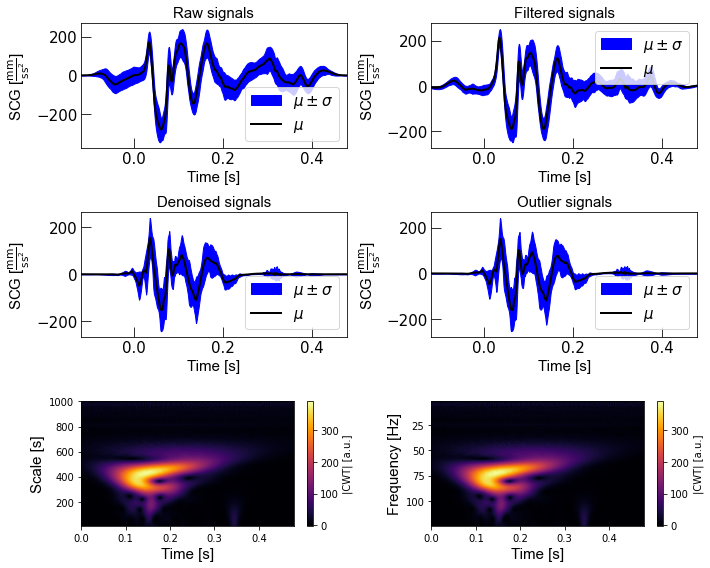

Subject 58: Number of recorded heart beats (HB): 113, and data points per HB: 878 


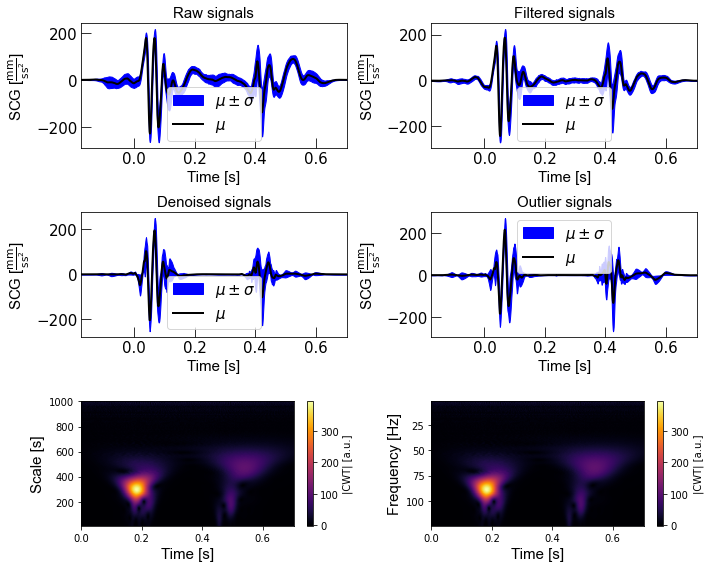

Subject 59: Number of recorded heart beats (HB): 144, and data points per HB: 834 


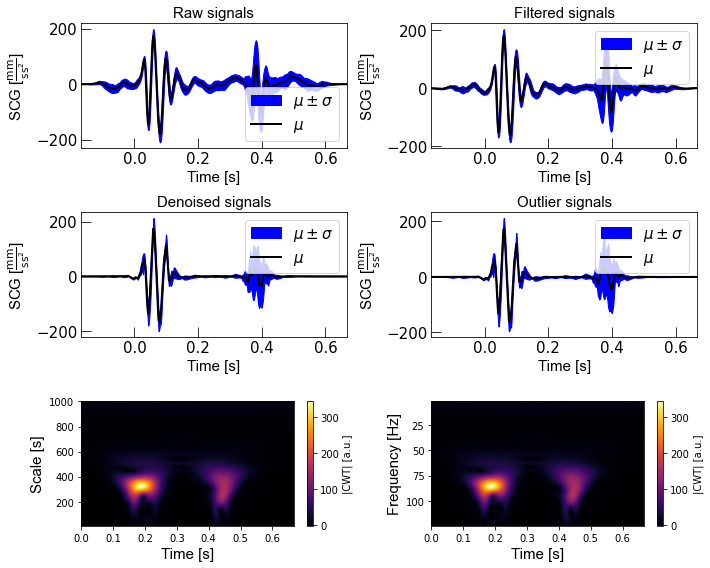

Subject 60: Number of recorded heart beats (HB): 110, and data points per HB: 1066 


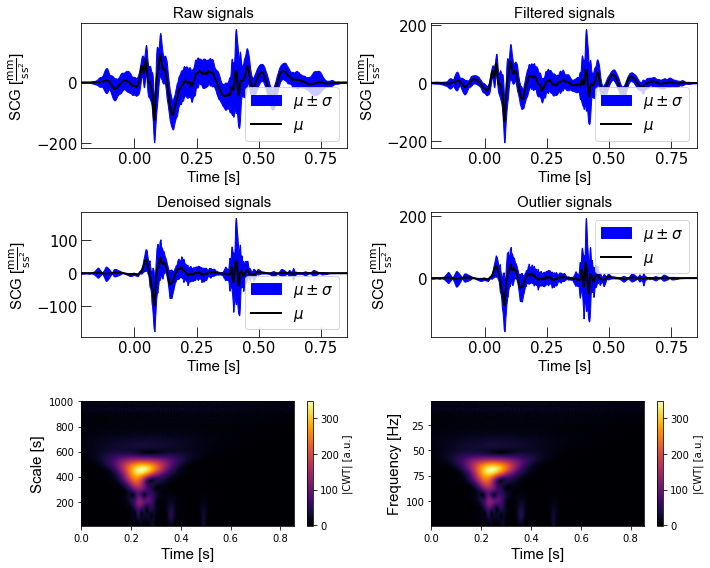

Subject 61: Number of recorded heart beats (HB): 79, and data points per HB: 981 


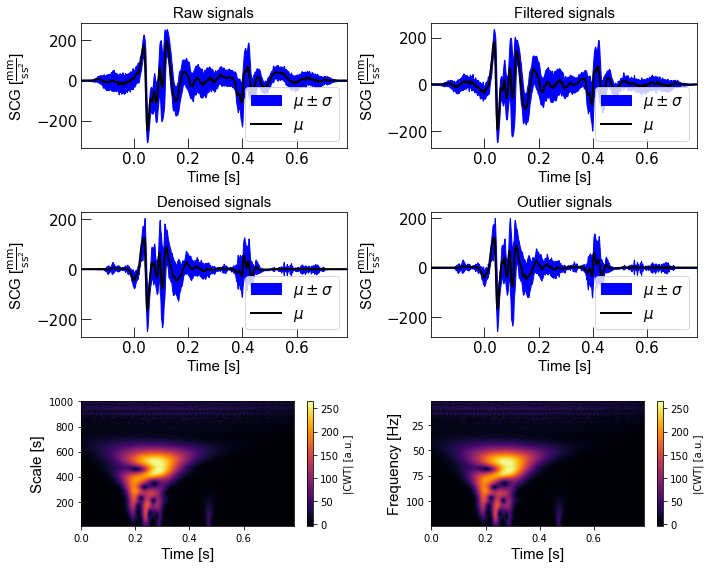

Subject 62: Number of recorded heart beats (HB): 103, and data points per HB: 664 


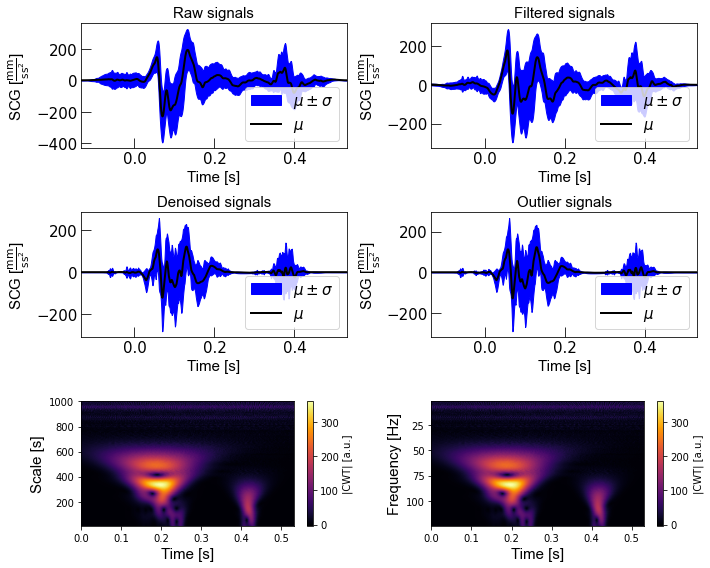

Subject 63: Number of recorded heart beats (HB): 105, and data points per HB: 933 


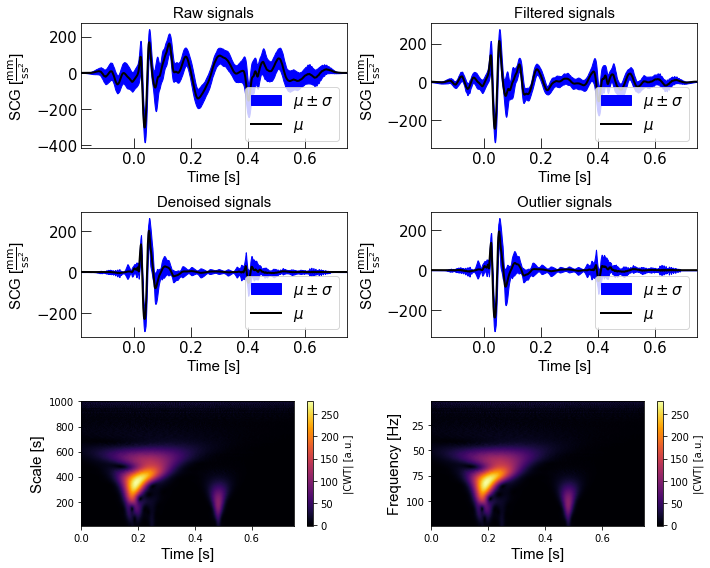

Subject 64: Number of recorded heart beats (HB): 11, and data points per HB: 887 


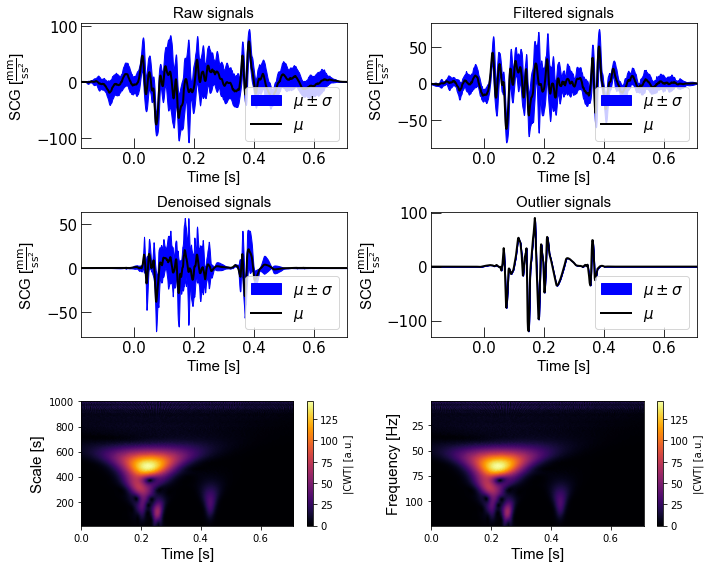

Subject 65: Number of recorded heart beats (HB): 143, and data points per HB: 904 


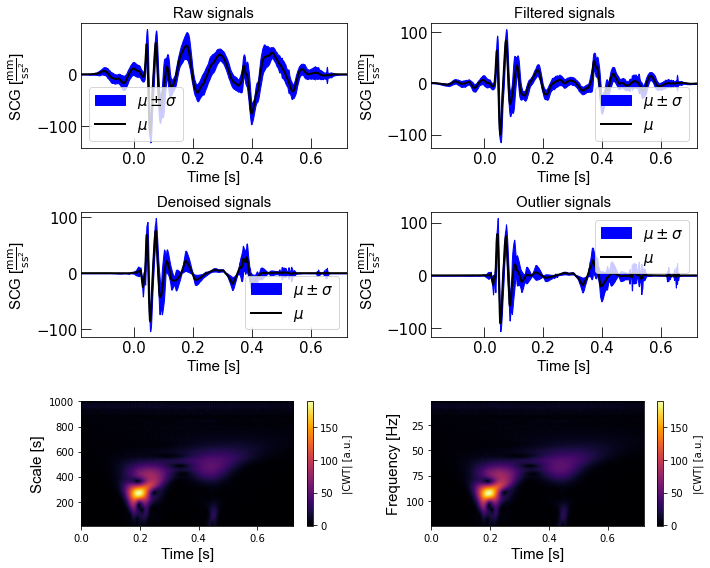

Subject 66: Number of recorded heart beats (HB): 178, and data points per HB: 723 


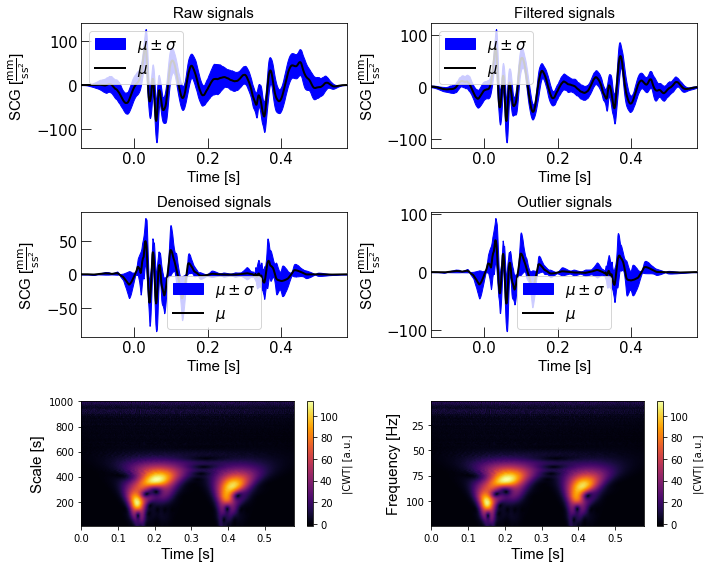

Subject 67: Number of recorded heart beats (HB): 175, and data points per HB: 697 


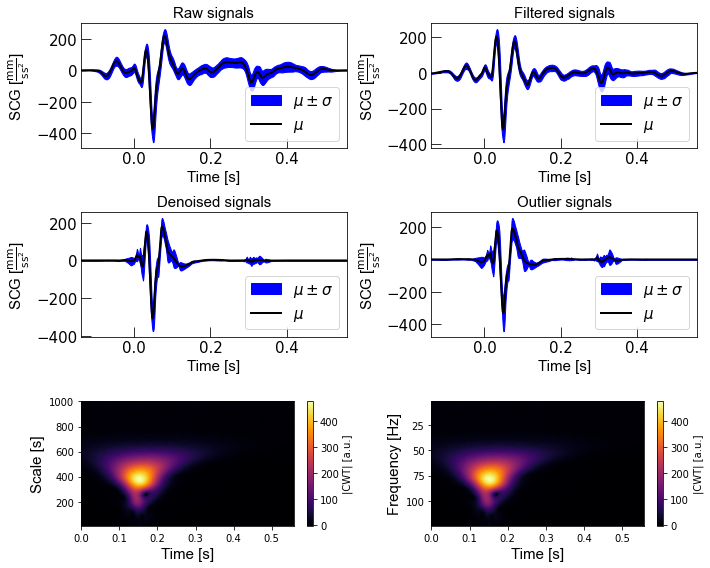

Subject 68: Number of recorded heart beats (HB): 133, and data points per HB: 956 


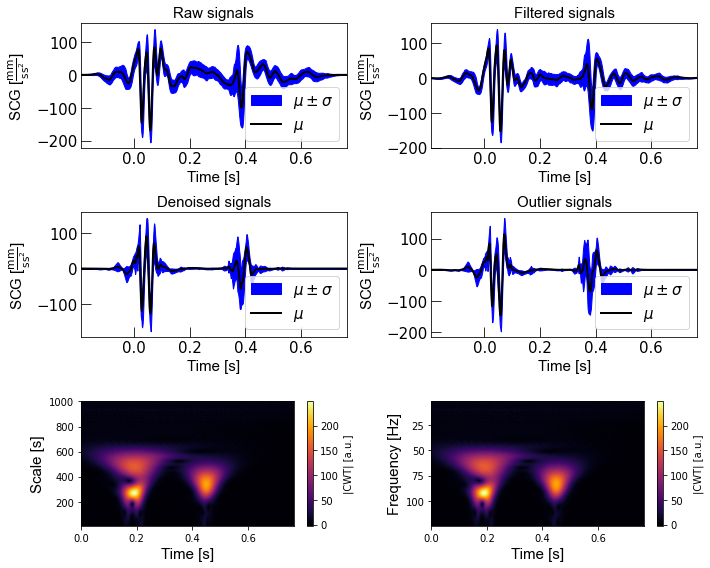

Subject 69: Number of recorded heart beats (HB): 167, and data points per HB: 758 


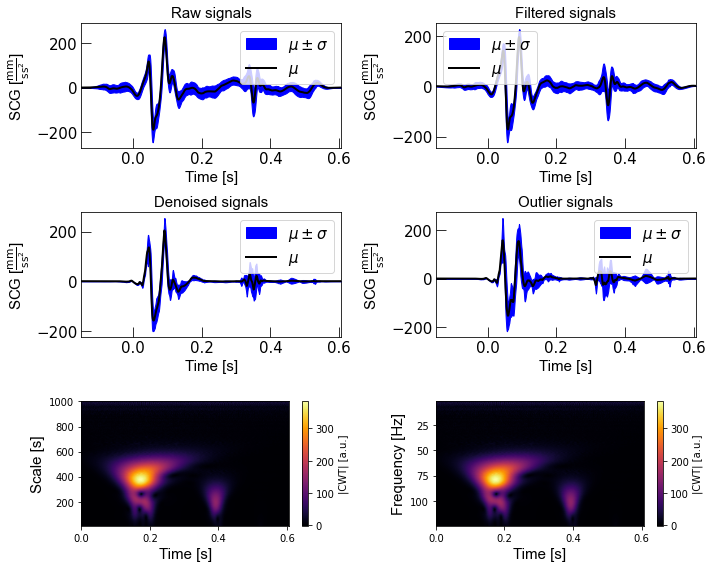

Subject 70: Number of recorded heart beats (HB): 129, and data points per HB: 872 


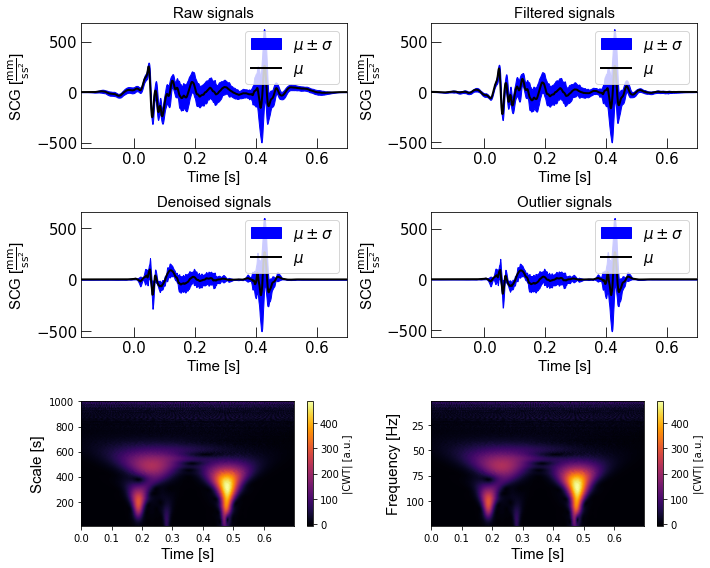

Subject 71: Number of recorded heart beats (HB): 35, and data points per HB: 767 


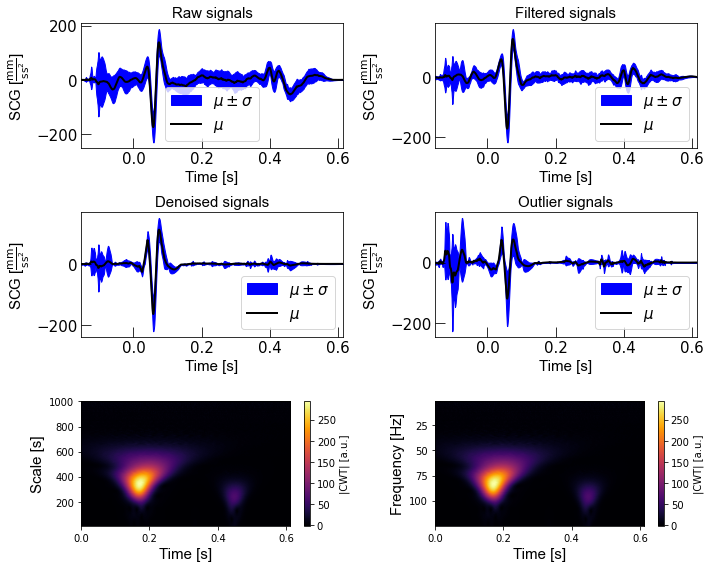

Subject 72: Number of recorded heart beats (HB): 133, and data points per HB: 795 


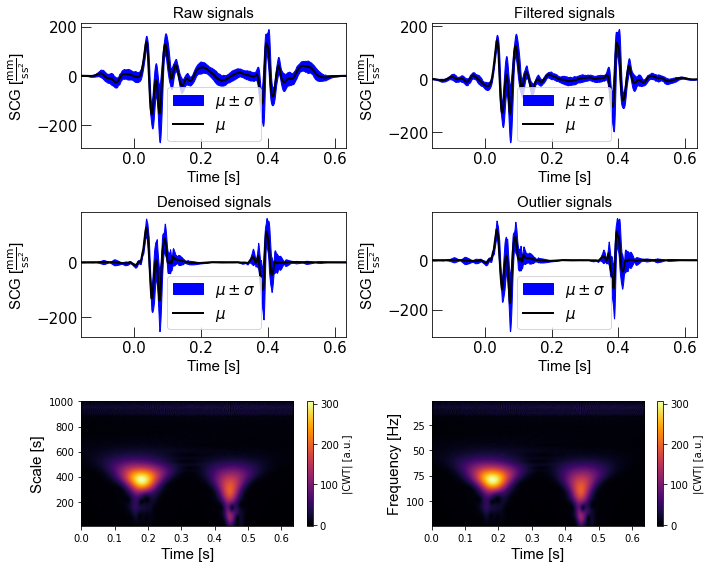

Subject 73: Number of recorded heart beats (HB): 189, and data points per HB: 636 


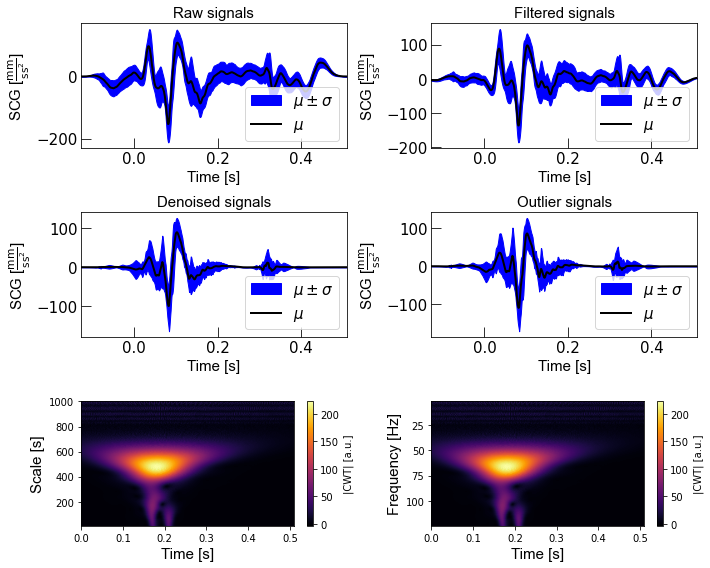

Subject 74: Number of recorded heart beats (HB): 114, and data points per HB: 925 


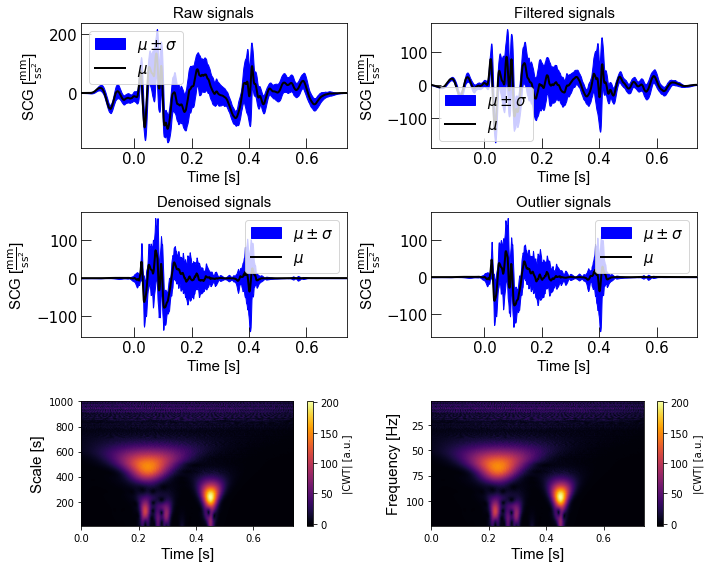

Subject 75: Number of recorded heart beats (HB): 133, and data points per HB: 868 


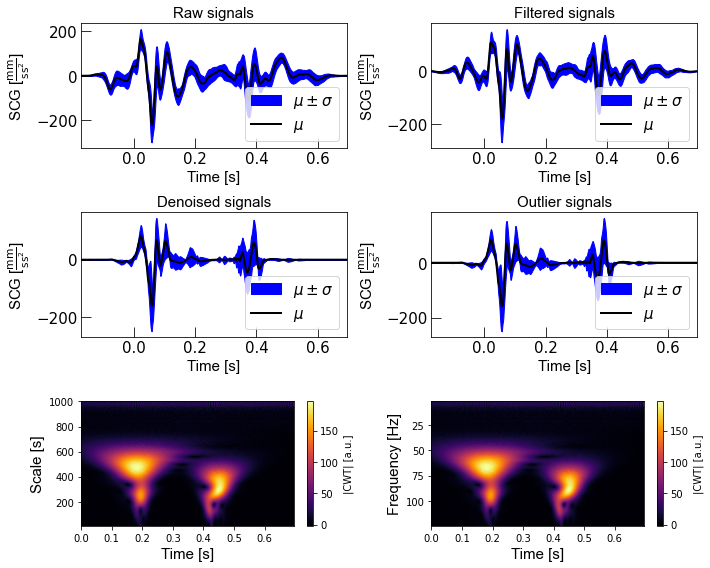

Subject 76: Number of recorded heart beats (HB): 125, and data points per HB: 932 


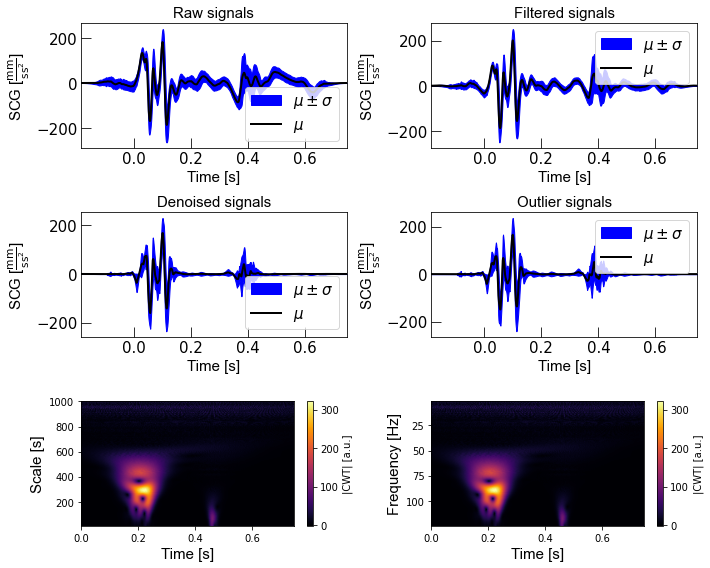

In [6]:
def thresh(d, N, axis=None):
    """
    Calculate the threshold value for denoising the signal using the mean absolute deviation
    :param d: 1D numpy array, input signal
    :param N: int, length of the input signal
    :param axis: int, axis along which the mean is calculated. None by default
    :return: float, threshold value
    """
    mad = np.mean(np.absolute(d - np.mean(d, axis)), axis)
    sigma = (1/0.6745) * mad 
    return sigma * np.sqrt(2 * np.log(len(d)))

def denoise_signal(signal, wavelet='sym4'):
    """
    Denoise the input signal using wavelet denoising
    :param signal: 1D numpy array, input signal
    :param wavelet: str, name of the wavelet to be used for denoising. 'sym4' by default
    :return: 1D numpy array, denoised signal
    """
    w = pywt.Wavelet(wavelet)
    max_level = pywt.dwt_max_level(data_len=len(signal), filter_len=w.dec_len)
    coeff = pywt.wavedec(signal, wavelet, mode='symmetric', level=max_level)
    coeff[:] = (pywt.threshold(d, value=thresh(d,len(signal)), mode="hard") for d in coeff[:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode='symmetric')
    return reconstructed_signal

def plot_signals(ax, scg, title, fontsize=15):
    scg_mu = np.mean(scg, axis=1)
    scg_sd = np.std(scg, axis=1)
    ax.fill_between(t, scg_mu - scg_sd, scg_mu + scg_sd, color='b', label=r'$\mu\pm\sigma$')
    ax.plot(t, scg_mu, color='k', linewidth=2, label=r'$\mu$')
    ax.set_title(title, fontsize=fontsize, fontname='arial')
    ax.set_xlabel('Time [s]', fontsize=fontsize, fontname='arial')
    ax.set_ylabel(r'SCG [$\frac{\mathrm{mm}}{\mathrm{ss}^2}$]', fontsize=fontsize, fontname='arial')
    ax.set_xlim(t[0], t[-1])
    ax.tick_params(which='both', direction='in', length=10, labelsize=fontsize)
    ax.legend(fontsize=fontsize)
    
def scale_selection(t, voicesperoctave=32, wavelet='cmor1.5-1.0'):
    '''
    This function calculates the frequency corresponding to different start and end scales for a Continuous Wavelet Transform (CWT) of a signal.

    Parameters:
    t: array-like
        The time values corresponding to the signal
    voicesperoctave: int (optional)
        The number of voices per octave for the scales of the CWT
    wavelet: str (optional)
        The wavelet to be used in the CWT

    Returns:
    None
    '''
    # Sampling interval
    dt = np.mean(np.diff(t))
    # Sampling frequency
    fs = 1/dt
    # Step between the scales
    step = 1/voicesperoctave
    # Starting scale options
    start_scale_options = [-1, 0, 1, 2, 3, 4]
    # Stopping scale options
    stop_scale_options = [5, 6, 7, 8, 9, 10]
    # Loop over different start and end scale options
    for start_scale in start_scale_options:
        for stop_scale in stop_scale_options:
            # Calculate the scales
            scales = 2**(np.arange(start_scale, stop_scale, step))
            # Perform the Continuous Wavelet Transform (CWT)
            freqs = pywt.scale2frequency(wavelet, scales) * fs
            # Find the corresponding frequency
            min_frequency = min(freqs)
            max_frequency = max(freqs)
            print(f"start scale: {start_scale}, end scale: {stop_scale}: , min_freq = {min_frequency:.2f} Hz, max_freq={max_frequency/1000:.2f} kHz")
    return None
    
def scalogram(signal, t, wavelet='cmor1.5-1.0'):
    '''
    This function performs Continuous Wavelet Transform (CWT) on a given signal and returns the resized CWT matrix.
    
    Parameters:
    signal: array-like
        The signal to be transformed
    t: array-like
        The time values corresponding to the signal
        
    Returns:
    cwtmatr_resized: array-like
        The resized CWT matrix
    '''
    # pywt.wavelist(kind='continuous') # list of availabe wavelets for pywt.cwt
    # Sampling interval
    dt = np.mean(np.diff(t))
    # Sampling frequency
    fs = 1/dt
    # Number of voices per octave
    voicesperoctave = 32
    # Step between the scales
    step = 1/voicesperoctave
    # Starting scale
    start_scale = 3
    # Stopping scale
    stop_scale = 10
    # Calculate the scales
    scales = 2**(np.arange(start_scale, stop_scale, step))
    # Perform the Continuous Wavelet Transform (CWT)
    cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)
    # Interpolate the CWT matrix
    interp = RectBivariateSpline(np.arange(cwtmatr.shape[0]), np.arange(cwtmatr.shape[1]), abs(cwtmatr))
    cwtmatr_resized = interp(np.linspace(0, cwtmatr.shape[0]-1, 256), np.linspace(0, cwtmatr.shape[1]-1, 256))
    
    return cwtmatr_resized, scales, freqs

# Initialize the dictionary to save the data
data = {}

for ii, path in enumerate(df['scg_files'].astype(str)):

    # Read the contents of the file using "read_mat()" and store the 'scg' data from the 'ax' key in a variable "scg".
    scg = read_mat(path)['ax']['scg']

    # Read the contents of the file using "read_mat()" and store the 't' data from the 'ax' key in a variable "t".
    t = read_mat(path)['ax']['t']

    # Define variable "wn" as the number of samples in a window (here it is set to be 1/4 of the total number of samples) with an extra sample if necessary.
    wn = scg.shape[0]//4 + scg.shape[0]//4 % 2

    # Create a Blackman window of length "wn".
    bm_win = np.blackman(wn)

    # Concatenate the Blackman window and an array of ones of length equal to the total number of samples minus the length of the Blackman window.
    # Then, reshape the concatenated array to a 2D array with one column.
    window = np.concatenate((bm_win[:wn//2+1], np.ones(scg.shape[0]-wn), bm_win[wn//2+1:])).reshape(-1,1)

    # Apply the window to the SCG data by element-wise multiplication.
    scg = window * scg

    fig, axs = plt.subplots(3, 2, figsize=(10,8))

    # Visualize the windowed signasl
    plot_signals(axs[0][0], scg, 'Raw signals')
    print(f"Subject {ii}: Number of recorded heart beats (HB): {scg.shape[1]}, and data points per HB: {scg.shape[0]} ")

    # Derive the sampling period and the sampling frequency
    dt = np.mean(np.diff(t))
    fs = 1/dt

    # High pass filter all the SCG signals
    cutoff = 10  
    order = 5    
    b, a = signal.butter(order, cutoff / (fs/2), 'highpass')
    for jj in range(scg.shape[1]):
        scg[:, jj] = signal.filtfilt(b, a, scg[:, jj])

    # Visualize the high-pass filtered SCG signals
    plot_signals(axs[0][1], scg, 'Filtered signals')

    # Denoise the SCG signals
    for jj in range(scg.shape[1]):
        scg[:, jj] = denoise_signal(scg[:, jj])[:scg.shape[0]]

    # Visualize the denoised signals
    plot_signals(axs[1][0], scg, 'Denoised signals')
    
    # Distance will record the Euclidean distance between the SCGs and the mean SCG
    dist = np.zeros(shape=(scg.shape[1],1))
    
    # Find the mean denoised SCG
    scg_mu = np.mean(scg, axis=1)
    
    # Calculate the distance 
    for jj in range(scg.shape[1]):
        dist[jj],_ = fastdtw(scg[:,jj], scg_mu, dist=euclidean)
        
    # Calculate the SQI (signal quality index)
    SQI = np.exp(-dist/scg.shape[0])
    
    # Determine the outlier exclusion criteria
    threshold = 0.05*np.max(SQI)
    
    # Remove the outliers
    scg_outliers = scg[:,np.squeeze(SQI<threshold)]
    scg = scg[:,np.squeeze(SQI>=threshold)]
    
    # Visualize the outliers
    plot_signals(axs[1][1], scg_outliers, 'Outlier signals')
    
    scalograms = np.zeros(shape=(256,256,scg.shape[1]))
    # Calculate the scalograms
    for jj in range(scg.shape[1]):
        scalograms[:,:,jj], scales, freqs = scalogram(scg[:,jj], t, wavelet='cmor1.5-1.0')
            
    # Plot an example time-scale image
    im = axs[2][0].imshow(scalograms[:,:,0], extent=[0, t[-1], scales[0], scales[-1]],
                          cmap='inferno', aspect='auto', origin='lower')
    axs[2][0].set_xlabel('Time [s]', fontsize=15, fontname='arial')
    axs[2][0].set_ylabel('Scale [s]', fontsize=15, fontname='arial')
    cb = fig.colorbar(im, ax=axs[2][0])
    cb.set_label('|CWT| [a.u.]')
    
    # Plot an example time-frequency image
    im = axs[2][1].imshow(scalograms[:,:,0], extent=[0, t[-1], freqs[0], freqs[-1]], 
                          cmap='inferno', aspect='auto', origin='lower')
    axs[2][1].set_xlabel('Time [s]', fontsize=15, fontname='arial')
    axs[2][1].set_ylabel('Frequency [Hz]', fontsize=15, fontname='arial')
    cb = fig.colorbar(im, ax=axs[2][1])
    cb.set_label('|CWT| [a.u.]')
    
    fig.tight_layout()
    plt.show()
    
    matching_row = df.index[df['scg_files'] == path].tolist()[0]

    # Get the value of 'subjectid' column at the matching row
    subjid = df.loc[matching_row, 'subjid']
                            
    # Save the subjects scalograms, attributes, and as_valve condition 
    data[subjid] = {'scalogram':scalograms,
                    'attr':df.loc[matching_row, ['sex','age [y]','ht [m]','wt [kg]']].tolist(),
                    'as_valve':encAsValve_dict[subjid]}

## Define the models

There are two models:

1. **MLP**
    - The input of the MLP is the demographic information of the subjects, including their weight, height, age, and gender.
    - The MLLP is composed of two fully-connected dense layers. 
    - All three continuous attributes are min-max normalized, and the participants' gender are one-hot encoded (i.e. female = 1, male = 0) before being fed into the MLP.  
    
2. **CNN**
    - The input of the CNN model are the scalograms of the recorded SCG pulses.
    - The CNN architecture consisted of a stack of five convolutional blocks, with each block containing a sequence of Conv2D, ReLU (rectified linear unit) activation, batch normalization, and max pooling layers. 

In [261]:
# MLP model
def create_mlp(dim):
    # define the Multilayer Perceptron (MLP) network:
    model = Sequential()
    model.add(Dense(8,input_dim=dim,activation="relu"))
    model.add(Dense(4,activation="relu"))
    # return the model
    return model

# CNN model
def create_cnn(input_shape=(256, 256, 1), num_filters=[64, 128, 256, 512], augmentation=False):
    # define the model input
    inputs = Input(shape=input_shape)
    
    # data augmentation
    if augmentation:
        x = RandomFlip("horizontal")(inputs)
        x = RandomRotation(0.1)(x)
        x = RandomZoom(0.2)(x)
        x = inputs
        
    # add multiple Conv2D and MaxPooling2D layers
    for i, filter in enumerate(num_filters):
        # if this is the first layer, set the input appropriately
        if i == 0 and not augmentation:
            x = inputs
        # Conv2D layer
        x = Conv2D(filter, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        # MaxPooling2D layer
        x = MaxPooling2D(pool_size=2)(x)
        
    # flatten the volume, then FC=>RELU=>BN=>DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    # apply anothe layer of FC layer, this one matches the number of nodes
    # coming out of the MLP 
    x = Dense(4)(x)
    outputs = Activation("relu")(x)
    
    # create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # return the CNN model
    return model

## Training and test of the model using Stratified KFold Cross validation

In [268]:
# Repeated Stratified K-Fold cross validator OBJECT
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=0)

# Define a grouping array based on encAsValve
groups = np.argmax(encAsValve, axis=1)

# Define a list containing dictionaries of the indices of the training and test sets
cv_subjs = []
subjs = list(data.keys())
try:
    for train_index, test_index in rskf.split(np.arange(0, len(data)), groups):
        cv_subjs.append({'train_subjs': [subjs[index] for index in train_index],
                        'test_subjs': [subjs[index] for index in test_index]})

except Exception as e:
    print("Error during cross-validation:", e)

    
# The epoch at which the learning rate will start to decay
start_decay_epoch = 5
# The rate at which the learning rate will be decreased
decay_rate = 0.1
# Define the learning rate schedule function, to decrease the learning rate at a specific epoch
def schedule(epoch, lr):
    return lr if epoch < start_decay_epoch else lr * decay_rate
#Apply the learning rate schedule as a callback to the training process
callbacks_lr = callbacks.LearningRateScheduler(schedule)

# A list to store the results from each cross-validation run
cv_results = []

 # Loop through each cross-validation subject set
for cv_counter, cv_subject in enumerate(cv_subjs):
    # Get the subjects used for training in this cross-validation run
    train_subjects = cv_subject['train_subjs']
    # Get the data corresponding to the training subjects
    training_data = [data[subj] for subj in train_subjects]
    
    # Initialize empty lists to store the scalograms, attributes, and valve labels
    scalogram_list, attribute_list, valve_labels = [], [], []
   
    # Loop through each subject in the training data
    for training_subject_data in training_data:  
        # Get the scalograms from the training data
        scalograms = training_subject_data['scalogram']
        # Get the attributes from the training data and repeat them for each scalogram
        attributes = [training_subject_data['attr']] * scalograms.shape[-1] 
        # Get the attributes from the training data and repeat them for each scalogram
        valve_label = [training_subject_data['as_valve']] * scalograms.shape[-1]
        
        # Append the scalograms to the scalogram list
        scalogram_list.append(np.transpose(scalograms,(2,0,1)))
        # Append the attributes to the attribute list
        attribute_list.append(attributes)
        # Append the valve labels to the valve label list
        valve_labels.append(valve_label)

    # Concatenate the scalograms from all subjects into a single array
    scalograms = np.concatenate(scalogram_list, axis=0)
    # Concatenate the attributes from all subjects into a single array
    attributes = np.concatenate(attribute_list, axis=0)
    # Concatenate the valve labels from all subjects into a single array
    valve_labels = np.concatenate(valve_labels, axis=0)
    
    # Prepare the input data for the model, including both the attributes and the scalograms
    train_x = [attributes, np.expand_dims(scalograms,axis=-1)]
    # Prepaare the labes
    train_y = valve_labels
    
    # Get the subjects used for test in this cross-validation run
    test_subjects = cv_subject['test_subjs']
    # Get the data corresponding to the test subjects
    test_data = [data[subj] for subj in test_subjects]
    
    # Initialize empty lists to store the scalograms, attributes, and valve labels
    scalogram_list, attribute_list, valve_labels = [], [], []
   
    # Loop through each subject in the teset data
    for test_subject_data in test_data:  
        # Get the scalograms from the test data
        scalograms = test_subject_data['scalogram']
        # Get the attributes from the test data and repeat them for each scalogram
        attributes = [test_subject_data['attr']] * scalograms.shape[-1] 
        # Get the attributes from the test data and repeat them for each scalogram
        valve_label = [test_subject_data['as_valve']] * scalograms.shape[-1]
        
        # Append the scalograms to the scalogram list
        scalogram_list.append(np.transpose(scalograms,(2,0,1)))
        # Append the attributes to the attribute list
        attribute_list.append(attributes)
        # Append the valve labels to the valve label list
        valve_labels.append(valve_label)

    # Concatenate the scalograms from all subjects into a single array
    scalograms = np.concatenate(scalogram_list, axis=0)
    # Concatenate the attributes from all subjects into a single array
    attributes = np.concatenate(attribute_list, axis=0)
    # Concatenate the valve labels from all subjects into a single array
    valve_labels = np.concatenate(valve_labels, axis=0)
    
    # Prepare the input data for the model, including both the attributes and the scalograms
    test_x = [attributes, np.expand_dims(scalograms,axis=-1)]
    # Prepaare the labes
    test_y = valve_labels
    
    # Create a multi-layer perceptron (MLP) model with the specified number of attributes
    mlp = create_mlp(attributes.shape[1])
    # Create a Convolutional Neural Network (CNN) model with the specified input shape 
    # and number of filters, with augmentation set to False
    cnn = create_cnn(input_shape=scalograms.shape[1:3] + (1,), num_filters=[4,8,16,32,128], augmentation=False)
    
    # Combine the outputs of the MLP and CNN models using concatenation
    comb_output = concatenate([mlp.output, cnn.output])
    # Add a final dense layer with 4 nodes and a 'softmax' activation function to the combined outputs,
    # with an intermediate dense layer with 4 nodes and a 'relu' activation function
    output = Dense(4, activation='softmax', name='aortic_stenosis_valve')(Dense(4, activation='relu')(comb_output))
    # Define the combined model with both MLP and CNN inputs and the final dense layer outputs
    model = Model(inputs=[mlp.input, cnn.input], outputs=output)
    
    # Plot the model
    if cv_counter == 0:
        keras.utils.plot_model(model,show_shapes=True,dpi=64)

    # Compile the model using the Adam optimizer, 'categorical_crossentropy' loss function, and accuracy metrics
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss={'aortic_stenosis_valve': 'categorical_crossentropy'},
                  metrics={'aortic_stenosis_valve': 'accuracy'})

    # Train the model using the specified inputs, outputs, validation data, epochs, batch size, verbosity, and callbacks
    history = model.fit(x=train_x,
                        y=train_y,
                        validation_data=(test_x, test_y),
                        epochs=15,
                        batch_size=32,
                        verbose=2,
                        callbacks= [callbacks_lr,# Save the best model during the training process
                                    callbacks.ModelCheckpoint(f"mixed_mdl_class_{cv_counter}.keras",
                                        # Only save the best model based on the val_loss metric
                                       save_best_only=True,
                                       monitor="val_loss")])
    
    # Load the best model
    model = tf.keras.models.load_model(f"mixed_mdl_class_{cv_counter}.keras")

    # Predict the test data using the model
    preds = model.predict(test_x, verbose=2)
    
    # Record the results of this cross valdation in the "cv_results" list
    cv_results[cv_counter] = {'ground_truth': test_y, 'model_predictions': preds}

    # Calculate the ROC AUC score for each class
    roc_auc = [0] * preds.shape[-1]
    preds = np.array(preds)
    for i in range(preds.shape[-1]):
        roc_auc[i] = roc_auc_score(test_y[:,i], preds[:,i])
        
    # Get the accuracy values for training and validation sets
    training_accuracy = hist.history["accuracy"]
    validation_accuracy = hist.history["val_accuracy"]
    epochs = range(1, len(training_accuracy) + 1)

    # Plot the accuracy values
    plt.figure()
    plt.plot(epochs, training_accuracy, 'b-', label="Training")
    plt.plot(epochs, validation_accuracy, 'r-', label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"The mean ROC AUC value: {np.mean(roc_auc): 0.2f} ")
    plt.legend()
    plt.grid(True)
    plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Fine-turning the model hyper-parameters

We use scikit-learn Keras wrappers ```scikeras.wrappers``` and ```GridSearchCV``` to find the best hyperparameters for our model.

There are different hyperparameters that can be tuned using this technique, for example: Batch-size, epochs, optimization algorithm, the learning rate, decay rate, and the momentum of the optimizer, acitivation functions, etc.

Here, there is an example of tuning the ```learning_rate``` and ```decay``` for Keras ```Adam``` optimizer

In [282]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# The create_model function will be used as the model argument in constructing the KerasClassifier wrapper
def create_model(learn_rate=0.01, decay=0.0, cnn_input_shape=(256,256,1)):
    # CNN model
    cnn = create_cnn(input_shape=cnn_input_shape, num_filters=[4,8,16,32,128], augmentation=False)
    # Output of the CNN model after two Dense layers
    output = Dense(4, activation="softmax", name='aortic_stenosis_valve')(Dense(4, activation="relu")(cnn.output))
    # Define the model inputs and outputs
    model = Model(inputs=cnn.input, outputs=output)
    # Define the model optimizer
    opt = Adam(learning_rate=learn_rate, decay=decay)
    # Compilte the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load an example data set
cv_subject = cv_subjs[0]

# Get the subjects used for training in this cross-validation run
train_subjects = cv_subject['train_subjs']
# Get the data corresponding to the training subjects
training_data = [data[subj] for subj in train_subjects]

# Initialize empty lists to store the scalograms, attributes, and valve labels
scalogram_list, attribute_list, valve_labels = [], [], []

# Loop through each subject in the training data
for training_subject_data in training_data:  
    # Get the scalograms from the training data
    scalograms = training_subject_data['scalogram']
    # Get the attributes from the training data and repeat them for each scalogram
    attributes = [training_subject_data['attr']] * scalograms.shape[-1] 
    # Get the attributes from the training data and repeat them for each scalogram
    valve_label = [training_subject_data['as_valve']] * scalograms.shape[-1]

    # Append the scalograms to the scalogram list
    scalogram_list.append(np.transpose(scalograms,(2,0,1)))
    # Append the attributes to the attribute list
    attribute_list.append(attributes)
    # Append the valve labels to the valve label list
    valve_labels.append(valve_label)

# Concatenate the scalograms from all subjects into a single array
scalograms = np.concatenate(scalogram_list, axis=0)
# Concatenate the attributes from all subjects into a single array
attributes = np.concatenate(attribute_list, axis=0)
# Concatenate the valve labels from all subjects into a single array
valve_labels = np.concatenate(valve_labels, axis=0)

# Prepare the input data for the model, including both the attributes and the scalograms
train_x = np.expand_dims(scalograms,axis=-1)
# Prepaare the labes
train_y = valve_labels

# Construct the KerasClassifier. This will be used as the estimator argument of the GridSearchCV.
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=2)
learn_rate = [0.0001, 0.001, 0.01, 0.1]
decay = [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
# Note the use of optimizer__, which is needed for the KerasCalssifier. Otherwise, it will give an error.
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__decay=decay)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [280]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])